In [2985]:
import os.path
import pickle as pk
from collections import Counter
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE, SMOTEN, RandomOverSampler
from qgrid import show_grid as exl
from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier,
                              VotingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, plot_confusion_matrix,
                             plot_roc_curve, roc_auc_score, confusion_matrix)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier
filterwarnings('ignore')

In [2446]:
def save(model, version_name=None, resource=0):
    '''
    Function to save trained model
    '''
    if resource:
        filename = f'Resources/{version_name}.pkl'
    else:
        filename = f'Models/model_{version_name}.pkl'
        
    with open(filename, 'wb') as file:
        pk.dump(model, file)
        
    return filename

In [1899]:
np.random.seed(441)
seed = 441

In [1900]:
df = pd.read_csv('train.csv')
df.drop('ID', inplace=True, axis=1)

In [1901]:
df.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [1902]:
df.isna().sum()

City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           11691
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
dtype: int64

In [1903]:
temp = df[df.isna().any(axis=1)]
temp

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
1,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
6,C3,679,Owned,Individual,28,28,No,NaN,NaN,NaN,17,10640.0,0
9,C1,530,Owned,Joint,59,26,Yes,NaN,7.0,4.0,18,21100.8,1
10,C28,600,Owned,Individual,21,21,No,X2,NaN,NaN,21,4068.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50867,C6,2040,Owned,Individual,37,37,No,X2,NaN,NaN,20,10016.0,0
50869,C11,1770,Rented,Individual,45,45,No,NaN,1.0,1.0,20,10944.0,0
50871,C10,224,Rented,Individual,21,21,No,NaN,1.0,1.0,13,11840.0,0
50876,C26,579,Owned,Individual,37,37,No,NaN,2.0,1.0,12,13222.0,0


In [1904]:
df['Health Indicator'].value_counts()

X1    13010
X2    10332
X3     6762
X4     5743
X5     1727
X6     1280
X7      196
X8       78
X9       63
Name: Health Indicator, dtype: int64

## Train Test Split & Report

In [1905]:
# temp dataframe
dft = df.fillna(-999)
dft = pd.get_dummies(dft)
x = dft.drop('Response', axis=1)
y = dft.Response

In [1906]:
50000*0.3

15000.0

In [1907]:
trainx, testx, trainy, testy = train_test_split(x, y, stratify=y, test_size=0.30, random_state=441)

In [1908]:
def report(model,trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=0):

    model.fit(trainx, trainy)
    print(f"Training Score = {model.score(trainx, trainy)}")
    print(f"Testing Score = {model.score(testx, testy)}")
    
    if cv:
        scores = cross_val_score(model, trainx, trainy, cv=5)
        print(f"Cross Validation Score = {np.mean(scores)}")    

    pred = model.predict(testx)
    pred_proba = model.predict_proba(testx)[:, 1]
    
#     pred_proba = (model.predict_proba(testx)>=0.3).astype(int)[:, 1]
#     pred = np.argmax((model.predict_proba(testx)>=0.3).astype(int),1)    

    print(f"ROC-AUC Score = {roc_auc_score(testy, pred_proba.reshape(-1, 1))}")

    print('\n\n-----------CLASSIFICATION REPORT-----------\n')
    print(classification_report(testy, pred))

    print('\n\n-----------ROC AUC CURVE-----------\n')
    plot_roc_curve(model, testx, testy)
    plt.show()

    print('\n\n-----------CONFUSION MATRIX-----------\n')
    plot_confusion_matrix(model, testx, testy)
    plt.show()
    
    return model

# <center> VERSION 1 </center>

Training Score = 0.7600583990790915
Testing Score = 0.7600393056010482
ROC-AUC Score = 0.5149916963397398


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.76      1.00      0.86     11602
           1       0.00      0.00      0.00      3663

    accuracy                           0.76     15265
   macro avg       0.38      0.50      0.43     15265
weighted avg       0.58      0.76      0.66     15265



-----------ROC AUC CURVE-----------



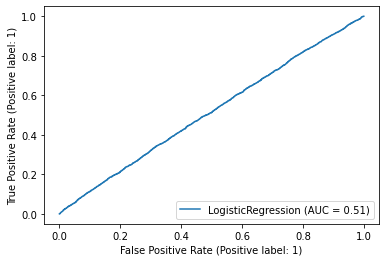



-----------CONFUSION MATRIX-----------



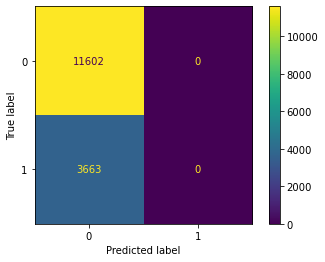

LogisticRegression(random_state=441)

In [1909]:
lr = LogisticRegression(random_state=seed)
report(lr)

Training Score = 0.7737316450009827
Testing Score = 0.7545365214543073
ROC-AUC Score = 0.6277905877543871


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.77      0.98      0.86     11602
           1       0.41      0.05      0.09      3663

    accuracy                           0.75     15265
   macro avg       0.59      0.51      0.47     15265
weighted avg       0.68      0.75      0.67     15265



-----------ROC AUC CURVE-----------



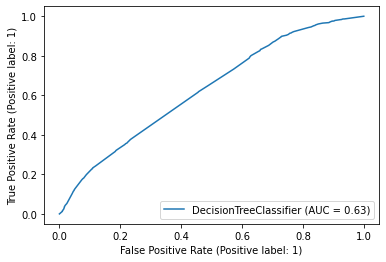



-----------CONFUSION MATRIX-----------



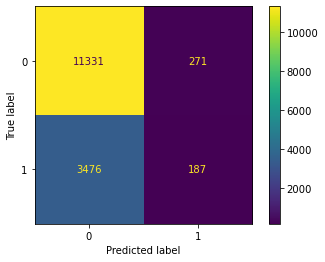

In [59]:
dtc = DecisionTreeClassifier(max_depth=10)
report(dtc)

Training Score = 0.7600583990790915
Testing Score = 0.7600393056010482
ROC-AUC Score = 0.5896420585698297


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.76      1.00      0.86     11602
           1       0.00      0.00      0.00      3663

    accuracy                           0.76     15265
   macro avg       0.38      0.50      0.43     15265
weighted avg       0.58      0.76      0.66     15265



-----------ROC AUC CURVE-----------



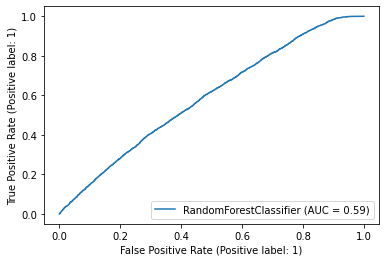



-----------CONFUSION MATRIX-----------



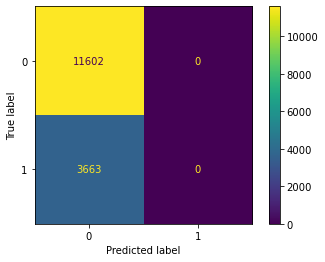

In [60]:
rf = RandomForestClassifier(max_depth=7)
report(rf)

# Oversampling SMOTE

In [62]:
ovrs = SMOTE(random_state=seed)
trainx, trainy = ovrs.fit_resample(trainx, trainy)
testx, testy = ovrs.fit_resample(testx, testy)

Training Score = 0.6930848509475084
Testing Score = 0.6941044647474574
ROC-AUC Score = 0.7696783208026269


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.69      0.71      0.70     11602
           1       0.70      0.68      0.69     11602

    accuracy                           0.69     23204
   macro avg       0.69      0.69      0.69     23204
weighted avg       0.69      0.69      0.69     23204



-----------ROC AUC CURVE-----------



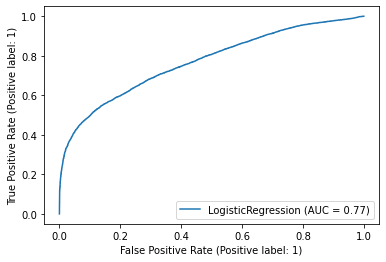



-----------CONFUSION MATRIX-----------



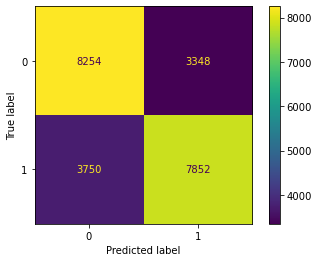

In [63]:
lr = LogisticRegression(random_state=seed)
report(lr,trainx=trainx, trainy=trainy, testx=testx, testy=testy)

Training Score = 0.7835321931217909
Testing Score = 0.7799517324599207
ROC-AUC Score = 0.8133043135154252


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.70      0.97      0.81     11602
           1       0.95      0.59      0.73     11602

    accuracy                           0.78     23204
   macro avg       0.83      0.78      0.77     23204
weighted avg       0.83      0.78      0.77     23204



-----------ROC AUC CURVE-----------



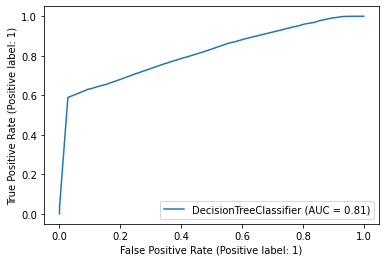



-----------CONFUSION MATRIX-----------



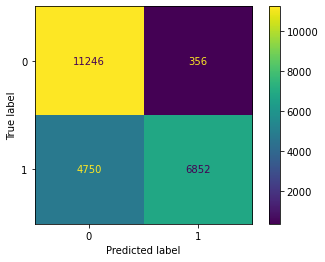

In [64]:
dtc = DecisionTreeClassifier(max_depth=7)
report(dtc,trainx=trainx, trainy=trainy, testx=testx, testy=testy)

Training Score = 0.8132872815928485
Testing Score = 0.8035252542665058
ROC-AUC Score = 0.8527695309355415


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.73      0.97      0.83     11602
           1       0.95      0.64      0.76     11602

    accuracy                           0.80     23204
   macro avg       0.84      0.80      0.80     23204
weighted avg       0.84      0.80      0.80     23204



-----------ROC AUC CURVE-----------



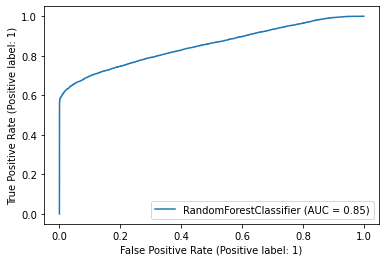



-----------CONFUSION MATRIX-----------



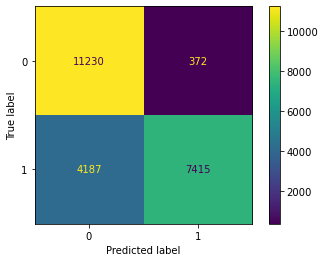

In [65]:
rf = RandomForestClassifier(max_depth=10, random_state=seed)
report(rf,trainx=trainx, trainy=trainy, testx=testx, testy=testy)

In [68]:
save(rf, 1)

'Models/model_1.pkl'

# <center> VERSION 2 </center>

In [1910]:
df.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [1911]:
df.isna().sum()

City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           11691
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
dtype: int64

In [1912]:
df2 = df.copy()

In [1913]:
df2.Holding_Policy_Duration.unique()

array(['14+', nan, '1.0', '3.0', '5.0', '9.0', '14.0', '7.0', '2.0',
       '11.0', '10.0', '8.0', '6.0', '4.0', '13.0', '12.0'], dtype=object)

In [1914]:
df2.Holding_Policy_Duration = df2.Holding_Policy_Duration.str.replace('14\+', '15')

df2.Holding_Policy_Duration = df2.Holding_Policy_Duration.fillna(0)

df2.Holding_Policy_Duration = df2.Holding_Policy_Duration.apply(lambda x: float(x)).astype('int64')

In [1915]:
df2.Holding_Policy_Type.unique()

array([ 3., nan,  1.,  4.,  2.])

In [1916]:
df2.Holding_Policy_Type = df2.Holding_Policy_Type.fillna(0).astype('category')

In [1917]:
df2.drop('Region_Code', axis=1, inplace=True)

In [1918]:
# Accomodation Type - 

# 0 - Rented
# 1 - Owned

In [1919]:
df2.Accomodation_Type = df2.Accomodation_Type.apply(
    lambda x: 0 if (x == 'Rented') else 1).astype('category')

In [1920]:
# Reco_Isurance_Type

# 0 - Individual
# 1 - Joint

In [1921]:
df2.Reco_Insurance_Type = df2.Reco_Insurance_Type.apply(
    lambda x: 0 if (x == 'Individual') else 1).astype('category')

In [1922]:
# Is_Spouse

# 0 - No
# 1 - Yes

In [1923]:
df2.Is_Spouse = df2.Is_Spouse.apply(lambda x: 0 if (x == 'No') else 1).astype('category')

In [1924]:
df2.Reco_Policy_Cat = df2.Reco_Policy_Cat.astype('category')

In [1925]:
df2['Health Indicator'].isna().sum()

11691

In [1926]:
df2['Health Indicator'].value_counts()

X1    13010
X2    10332
X3     6762
X4     5743
X5     1727
X6     1280
X7      196
X8       78
X9       63
Name: Health Indicator, dtype: int64

In [1927]:
df_for_newfeatures = df2.copy()

In [1928]:
hi = pd.get_dummies(df2['Health Indicator'].fillna('X0'))
hi

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9
0,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
50877,0,0,0,1,0,0,0,0,0,0
50878,0,0,0,1,0,0,0,0,0,0
50879,0,0,1,0,0,0,0,0,0,0
50880,0,0,1,0,0,0,0,0,0,0


In [1929]:
df2.drop('Health Indicator', inplace = True, axis=1)

In [1930]:
cc = pd.get_dummies(df2.City_Code)
cc.head()

,C1,C10,C11,C12,C13,C14,C15,C16,C17,C18,...,C33,C34,C35,C36,C4,C5,C6,C7,C8,C9
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [1931]:
df2.drop('City_Code', inplace = True, axis=1)

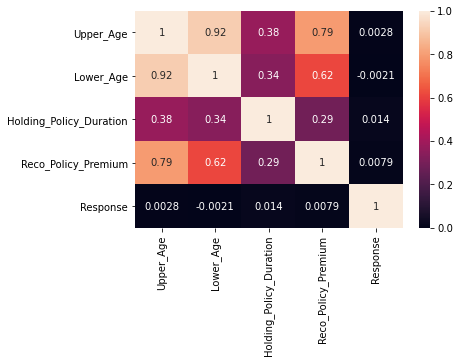

In [1932]:
sns.heatmap(df2.corr(), annot=True)

In [1933]:
df2 = pd.concat([df2, hi, cc], axis=1)
df2.head()

,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,...,C33,C34,C35,C36,C4,C5,C6,C7,C8,C9
0,0,0,36,36,0,15,3.0,22,11628.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,75,22,0,0,0.0,22,30510.0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,32,32,0,1,1.0,19,7450.0,1,...,0,0,0,0,0,1,0,0,0,0
3,1,1,52,48,0,15,3.0,19,17780.0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,44,44,0,3,1.0,16,10404.0,0,...,0,0,0,0,0,0,0,0,1,0


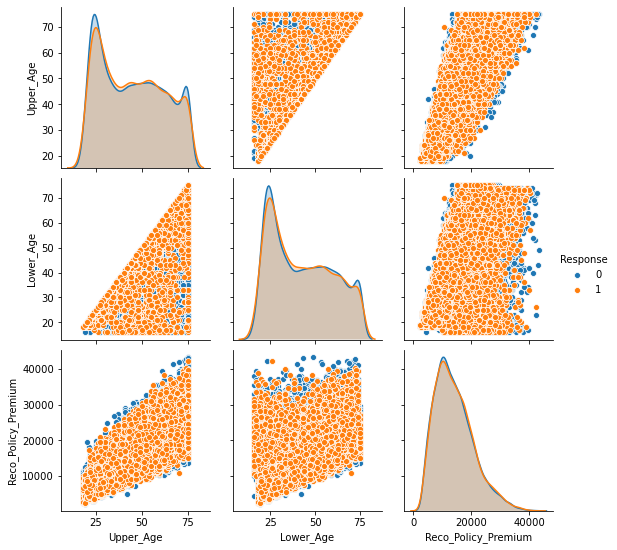

In [1934]:
sns.pairplot(df2[['Response', 'Upper_Age', 'Lower_Age','Reco_Policy_Premium']], hue='Response')

In [1935]:
x = df2.drop('Response', axis=1)
y = df2.Response

trainx, testx, trainy, testy = train_test_split(x, y, stratify=y, test_size=0.30, random_state=441)

In [596]:
ss = StandardScaler()
min_max = MinMaxScaler()
ss_ua = min_max.fit(trainx.Upper_Age.values.reshape(-1, 1))
ss_la = min_max.fit(trainx.Lower_Age.values.reshape(-1, 1))
ss_pr = ss.fit(trainx.Reco_Policy_Premium.values.reshape(-1, 1))

trainx.Upper_Age = ss_ua.transform(trainx.Upper_Age.values.reshape(-1, 1))
trainx.Lower_Age = ss_la.transform(trainx.Lower_Age.values.reshape(-1, 1))
trainx.Reco_Policy_Premium = ss_pr.transform(trainx.Reco_Policy_Premium.values.reshape(-1, 1))

testx.Upper_Age = ss_ua.transform(testx.Upper_Age.values.reshape(-1, 1))
testx.Lower_Age = ss_la.transform(testx.Lower_Age.values.reshape(-1, 1))
testx.Reco_Policy_Premium = ss_pr.transform(testx.Reco_Policy_Premium.values.reshape(-1, 1))

save(ss_ua, resource=1, res_name='ss_ua')
save(ss_la, resource=1, res_name='ss_la')
save(ss_pr, resource=1, res_name='ss_pr')

In [598]:
trainx = trainx.astype('int')
testx = testx.astype('int')

### Model Building

Training Score = 0.7600583990790915
Testing Score = 0.7600393056010482
Cross Validation Score = 0.7600584003090637
ROC-AUC Score = 0.5672612246478822


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.76      1.00      0.86     11602
           1       0.00      0.00      0.00      3663

    accuracy                           0.76     15265
   macro avg       0.38      0.50      0.43     15265
weighted avg       0.58      0.76      0.66     15265



-----------ROC AUC CURVE-----------



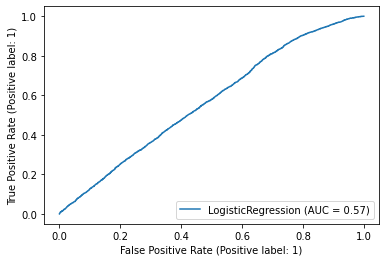



-----------CONFUSION MATRIX-----------



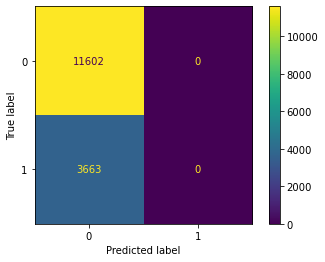

LogisticRegression(random_state=441)

In [149]:
lr = LogisticRegression(random_state=seed)
report(lr, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.7702782379200943
Testing Score = 0.7558467081559123
Cross Validation Score = 0.7526744861664332
ROC-AUC Score = 0.6302991807215217


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.77      0.96      0.86     11602
           1       0.46      0.11      0.17      3663

    accuracy                           0.76     15265
   macro avg       0.62      0.53      0.51     15265
weighted avg       0.70      0.76      0.69     15265



-----------ROC AUC CURVE-----------



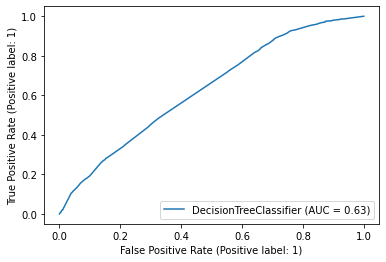



-----------CONFUSION MATRIX-----------



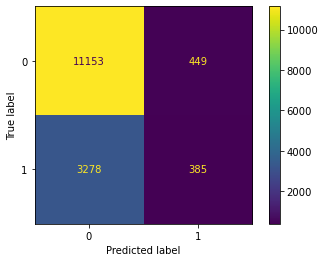

DecisionTreeClassifier(max_depth=10)

In [150]:
dtc = DecisionTreeClassifier(max_depth=10)
report(dtc,trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.7680882724541651
Testing Score = 0.7593842122502457
Cross Validation Score = 0.7597214596837489
ROC-AUC Score = 0.6150225071100783


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.76      1.00      0.86     11602
           1       0.32      0.00      0.00      3663

    accuracy                           0.76     15265
   macro avg       0.54      0.50      0.43     15265
weighted avg       0.65      0.76      0.66     15265



-----------ROC AUC CURVE-----------



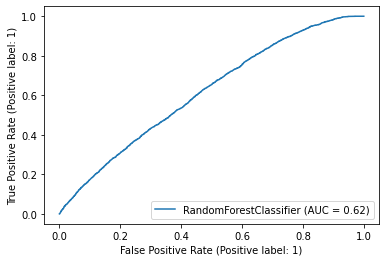



-----------CONFUSION MATRIX-----------



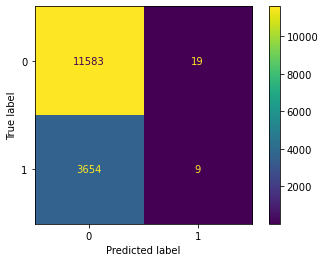

RandomForestClassifier(max_depth=18)

In [151]:
rf = RandomForestClassifier(max_depth=18)
report(rf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

In [152]:
trainx = trainx.astype('int')
testx = testx.astype('int')

[04:52:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score = 0.7856079961815987
Testing Score = 0.7568948575171962
[04:52:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:52:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

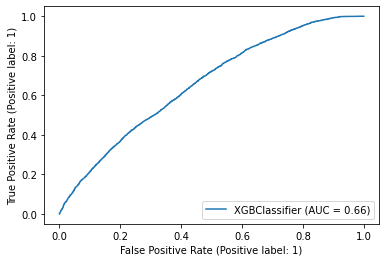



-----------CONFUSION MATRIX-----------



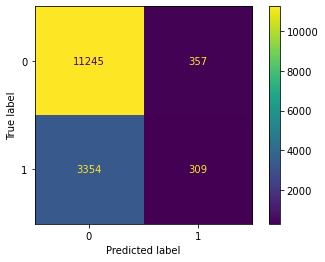

In [153]:
xgbclf = xgb.XGBClassifier(random_state=seed)
xgbclf = report(xgbclf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.9095095038885925
Testing Score = 0.711562397641664
Cross Validation Score = 0.7151640268537213
ROC-AUC Score = 0.6011321181550453


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.78      0.87      0.82     11602
           1       0.33      0.20      0.25      3663

    accuracy                           0.71     15265
   macro avg       0.55      0.54      0.54     15265
weighted avg       0.67      0.71      0.68     15265



-----------ROC AUC CURVE-----------



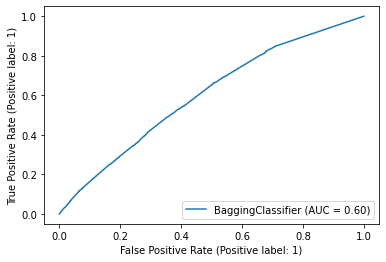



-----------CONFUSION MATRIX-----------



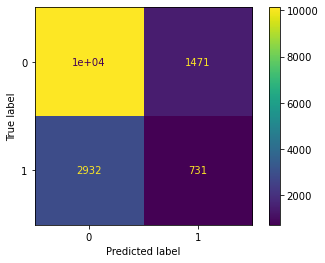

BaggingClassifier(random_state=0)

In [154]:
bg = BaggingClassifier(n_estimators=10, random_state=seed)
report(bg, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

## Oversampling V2

In [161]:
ovrs = SMOTE(random_state=seed)
trainx, trainy = ovrs.fit_resample(trainx, trainy)
testx, testy = ovrs.fit_resample(testx, testy)

Training Score = 0.7002696612611281
Testing Score = 0.7363816583347699
Cross Validation Score = 0.6963034260335375
ROC-AUC Score = 0.8066283087095916


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.70      0.84      0.76     11602
           1       0.80      0.63      0.71     11602

    accuracy                           0.74     23204
   macro avg       0.75      0.74      0.73     23204
weighted avg       0.75      0.74      0.73     23204



-----------ROC AUC CURVE-----------



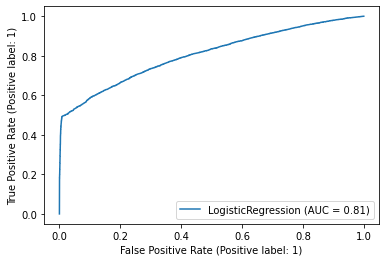



-----------CONFUSION MATRIX-----------



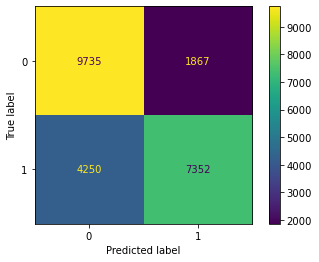

LogisticRegression(random_state=441)

In [163]:
lr = LogisticRegression(random_state=seed)
report(lr, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.6331498651693694
Testing Score = 0.6121789346664368
Cross Validation Score = 0.6116522651230365
ROC-AUC Score = 0.6449849555449085


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.65      0.49      0.56     11602
           1       0.59      0.73      0.65     11602

    accuracy                           0.61     23204
   macro avg       0.62      0.61      0.61     23204
weighted avg       0.62      0.61      0.61     23204



-----------ROC AUC CURVE-----------



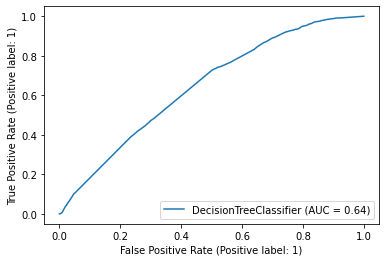



-----------CONFUSION MATRIX-----------



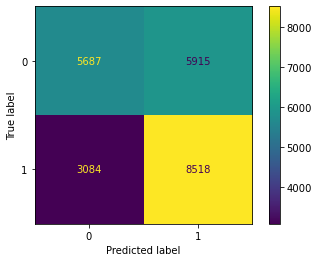

DecisionTreeClassifier(max_depth=10)

In [164]:
dtc = DecisionTreeClassifier(max_depth=10)
report(dtc,trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.8186805068154114
Testing Score = 0.6808308912256508
Cross Validation Score = 0.710467987029997
ROC-AUC Score = 0.7644036014809519


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.71      0.61      0.66     11602
           1       0.66      0.75      0.70     11602

    accuracy                           0.68     23204
   macro avg       0.68      0.68      0.68     23204
weighted avg       0.68      0.68      0.68     23204



-----------ROC AUC CURVE-----------



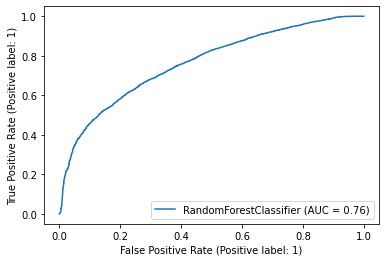



-----------CONFUSION MATRIX-----------



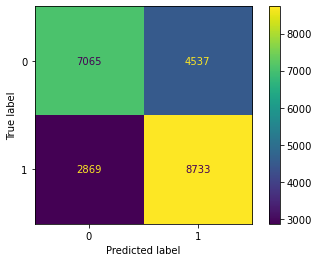

RandomForestClassifier(max_depth=18)

In [165]:
rf = RandomForestClassifier(max_depth=18)
report(rf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

[05:06:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score = 0.7753500055409848
Testing Score = 0.7434925012928806
[05:06:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:06:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

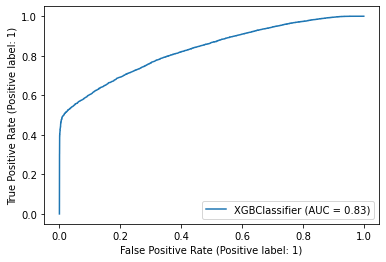



-----------CONFUSION MATRIX-----------



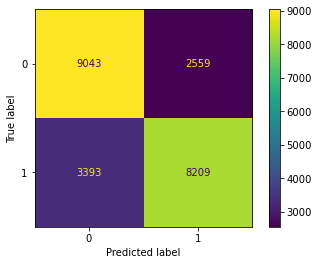

In [182]:
xgbclf = xgb.XGBClassifier(random_state=seed)
xgbclf = report(xgbclf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.9117136419046212
Testing Score = 0.6918203757972763
Cross Validation Score = 0.7564030869373692
ROC-AUC Score = 0.7624837671170535


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.67      0.75      0.71     11602
           1       0.72      0.63      0.67     11602

    accuracy                           0.69     23204
   macro avg       0.69      0.69      0.69     23204
weighted avg       0.69      0.69      0.69     23204



-----------ROC AUC CURVE-----------



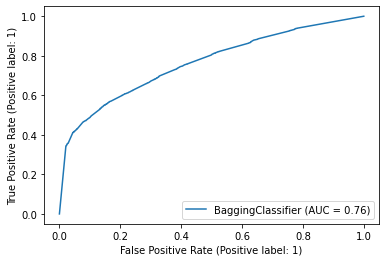



-----------CONFUSION MATRIX-----------



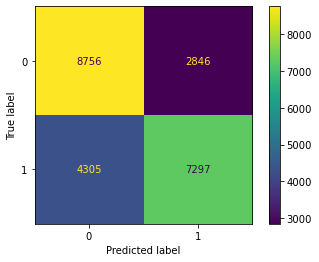

BaggingClassifier(random_state=441)

In [168]:
bg = BaggingClassifier(n_estimators=10, random_state=seed)
report(bg, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

In [183]:
save(xgbclf, 2)

'Models/model_2.pkl'

# <center> VERSION 3 </center>

In [3020]:
x = df2.drop('Response', axis=1)
y = df2.Response

x.Upper_Age = np.log10(x.Upper_Age)
x.Lower_Age = np.log10(x.Lower_Age)
x.Reco_Policy_Premium = np.log10(x.Reco_Policy_Premium)

trainx, testx, trainy, testy = train_test_split(x, y, stratify=y, test_size=0.30, random_state=441)

In [3021]:
trainx = trainx.astype('int')
testx = testx.astype('int')

### Model Building

Training Score = 0.7600583990790915
Testing Score = 0.7600393056010482
Cross Validation Score = 0.7600584003090637
ROC-AUC Score = 0.5692121459661539


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.76      1.00      0.86     11602
           1       0.00      0.00      0.00      3663

    accuracy                           0.76     15265
   macro avg       0.38      0.50      0.43     15265
weighted avg       0.58      0.76      0.66     15265



-----------ROC AUC CURVE-----------



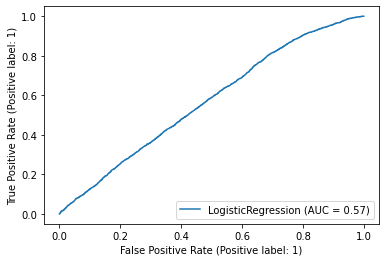



-----------CONFUSION MATRIX-----------



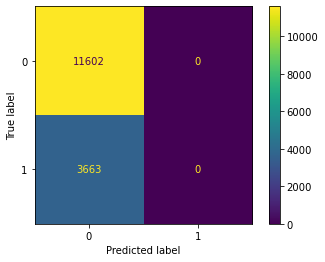

LogisticRegression(random_state=441)

In [1956]:
lr = LogisticRegression(random_state=seed)
report(lr, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.7703624673610916
Testing Score = 0.754208974778906
Cross Validation Score = 0.7531517697807428
ROC-AUC Score = 0.6302268128246409


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.77      0.96      0.86     11602
           1       0.45      0.11      0.17      3663

    accuracy                           0.75     15265
   macro avg       0.61      0.53      0.51     15265
weighted avg       0.70      0.75      0.69     15265



-----------ROC AUC CURVE-----------



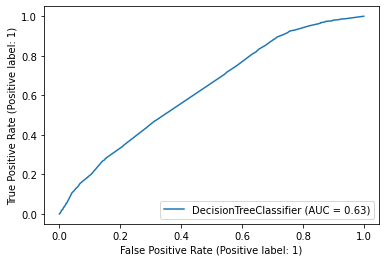



-----------CONFUSION MATRIX-----------



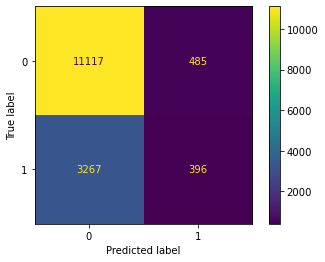

DecisionTreeClassifier(max_depth=10)

In [1957]:
dtc = DecisionTreeClassifier(max_depth=10)
report(dtc,trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.7671898250835275
Testing Score = 0.7597117589256469
Cross Validation Score = 0.7599180100240714
ROC-AUC Score = 0.6115967442893835


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.76      1.00      0.86     11602
           1       0.39      0.00      0.00      3663

    accuracy                           0.76     15265
   macro avg       0.58      0.50      0.43     15265
weighted avg       0.67      0.76      0.66     15265



-----------ROC AUC CURVE-----------



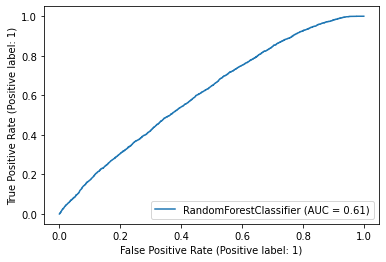



-----------CONFUSION MATRIX-----------



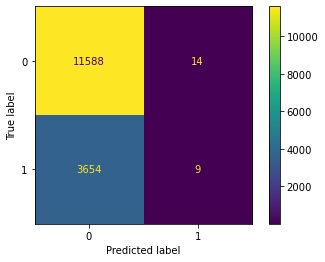

RandomForestClassifier(max_depth=18)

In [1958]:
rf = RandomForestClassifier(max_depth=18)
report(rf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

[09:54:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score = 0.785102619535615
Testing Score = 0.7593187029151655
[09:54:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:54:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


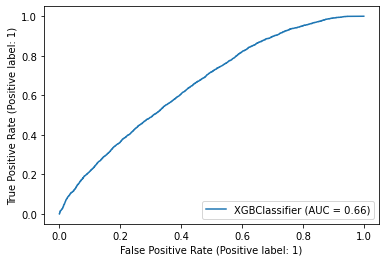



-----------CONFUSION MATRIX-----------



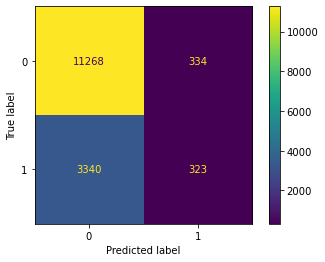

In [1959]:
xgbclf = xgb.XGBClassifier(random_state=seed)
xgbclf = report(xgbclf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.9034730606171211
Testing Score = 0.7118244349819849
Cross Validation Score = 0.7161748881429959
ROC-AUC Score = 0.6064450818372555


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.78      0.87      0.82     11602
           1       0.33      0.20      0.25      3663

    accuracy                           0.71     15265
   macro avg       0.55      0.54      0.54     15265
weighted avg       0.67      0.71      0.68     15265



-----------ROC AUC CURVE-----------



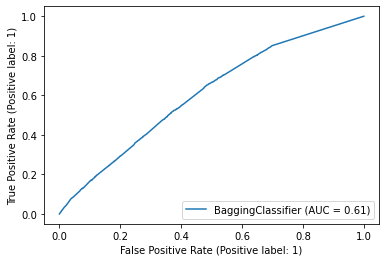



-----------CONFUSION MATRIX-----------



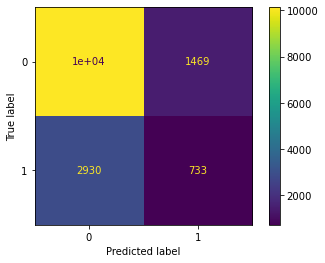

BaggingClassifier(random_state=441)

In [1960]:
bg = BaggingClassifier(n_estimators=10, random_state=seed)
report(bg, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

## Oversampling V3

In [1961]:
ovrs = SMOTE(random_state=seed)
trainx, trainy = ovrs.fit_resample(trainx, trainy)
testx, testy = ovrs.fit_resample(testx, testy)

Training Score = 0.6986812456133871
Testing Score = 0.7395707636614377
Cross Validation Score = 0.6947889399856444
ROC-AUC Score = 0.8098751564598665


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.69      0.86      0.77     11602
           1       0.81      0.62      0.71     11602

    accuracy                           0.74     23204
   macro avg       0.75      0.74      0.74     23204
weighted avg       0.75      0.74      0.74     23204



-----------ROC AUC CURVE-----------



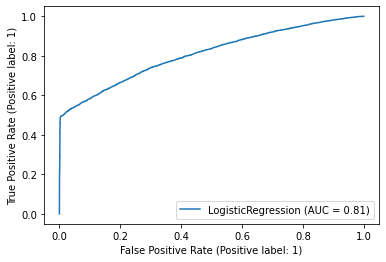



-----------CONFUSION MATRIX-----------



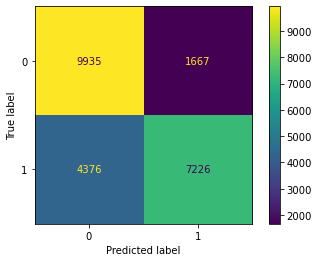

LogisticRegression(random_state=441)

In [1962]:
lr = LogisticRegression(random_state=seed)
report(lr, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.6283476783273614
Testing Score = 0.6073521806585072
Cross Validation Score = 0.6089554983142415
ROC-AUC Score = 0.6415780745468841


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.65      0.48      0.55     11602
           1       0.58      0.74      0.65     11602

    accuracy                           0.61     23204
   macro avg       0.62      0.61      0.60     23204
weighted avg       0.62      0.61      0.60     23204



-----------ROC AUC CURVE-----------



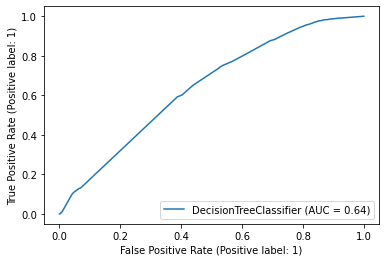



-----------CONFUSION MATRIX-----------



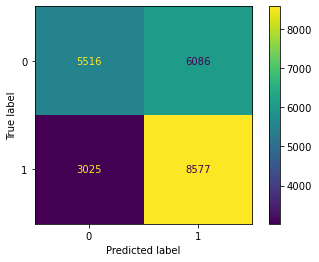

DecisionTreeClassifier(max_depth=10)

In [1963]:
dtc = DecisionTreeClassifier(max_depth=10)
report(dtc,trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.8354327509142625
Testing Score = 0.6891915187036718
Cross Validation Score = 0.7235075400396866
ROC-AUC Score = 0.7722301904744442


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.71      0.64      0.67     11602
           1       0.67      0.74      0.70     11602

    accuracy                           0.69     23204
   macro avg       0.69      0.69      0.69     23204
weighted avg       0.69      0.69      0.69     23204



-----------ROC AUC CURVE-----------



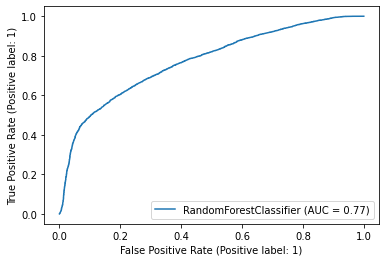



-----------CONFUSION MATRIX-----------



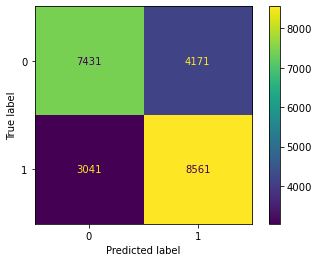

RandomForestClassifier(max_depth=18)

In [1964]:
rf = RandomForestClassifier(max_depth=18)
report(rf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

[09:55:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score = 0.7746112075652912
Testing Score = 0.7356059300120669
[09:55:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:55:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

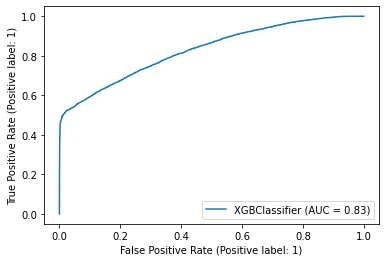



-----------CONFUSION MATRIX-----------



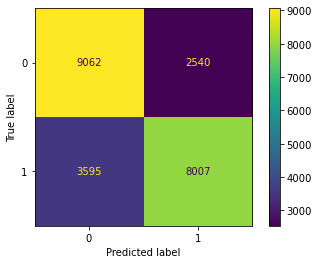

In [1965]:
xgbclf = xgb.XGBClassifier(random_state=seed, )
xgbclf = report(xgbclf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.9064312363784123
Testing Score = 0.7023358041716945
Cross Validation Score = 0.7632924074122275
ROC-AUC Score = 0.7728098285724949


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.68      0.76      0.72     11602
           1       0.73      0.64      0.68     11602

    accuracy                           0.70     23204
   macro avg       0.71      0.70      0.70     23204
weighted avg       0.71      0.70      0.70     23204



-----------ROC AUC CURVE-----------



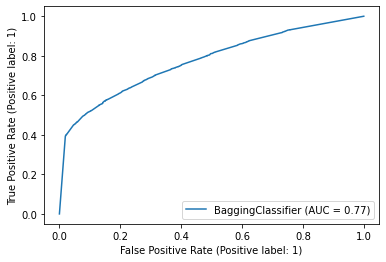



-----------CONFUSION MATRIX-----------



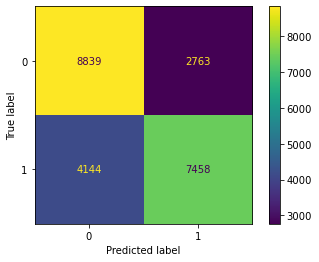

BaggingClassifier(random_state=441)

In [1966]:
bg = BaggingClassifier(n_estimators=10, random_state=seed)
report(bg, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.704351520076835
Testing Score = 0.748448543354594
ROC-AUC Score = 0.8141432297678793


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.69      0.92      0.79     11602
           1       0.88      0.58      0.70     11602

    accuracy                           0.75     23204
   macro avg       0.78      0.75      0.74     23204
weighted avg       0.78      0.75      0.74     23204



-----------ROC AUC CURVE-----------



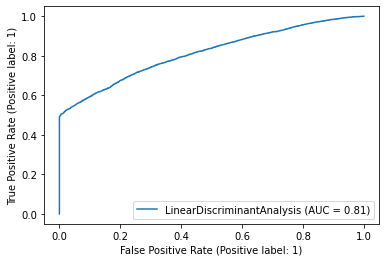



-----------CONFUSION MATRIX-----------



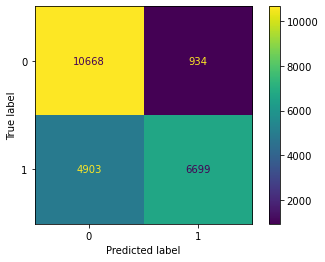

LinearDiscriminantAnalysis()

In [1967]:
lda = LinearDiscriminantAnalysis()
report(lda, trainx=trainx, trainy=trainy, testx=testx, testy=testy)

In [1968]:
save(xgbclf, '31')

'Models/model_31.pkl'

# <center>VERSION 4</center>

In [189]:
df4 = df2.copy()

In [190]:
df4.head()

,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,...,C33,C34,C35,C36,C4,C5,C6,C7,C8,C9
0,0,0,36,36,1,15,3.0,22,11628.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,75,22,1,0,0.0,22,30510.0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,32,32,1,1,1.0,19,7450.0,1,...,0,0,0,0,0,1,0,0,0,0
3,1,1,52,48,1,15,3.0,19,17780.0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,44,44,1,3,1.0,16,10404.0,0,...,0,0,0,0,0,0,0,0,1,0


In [191]:
mx = max(df4.Upper_Age.unique())
mx

75

In [192]:
mm = min(df4.Upper_Age.unique())
mm

18

In [193]:
def bin_age(x):
    if 0<=x<=30:
        return 1 # kids
    elif (x>30) and(x<=48):
        return 2 # Young
    elif (x>48) and(x<=65):
        return 3 # old
    else:
        return 4 # Very old

In [194]:
df4.Upper_Age = df4.Upper_Age.apply(bin_age)

In [195]:
df4.Lower_Age.max()

75

In [196]:
df4.Lower_Age.min()

16

In [197]:
df4.Lower_Age = df4.Lower_Age.apply(bin_age)

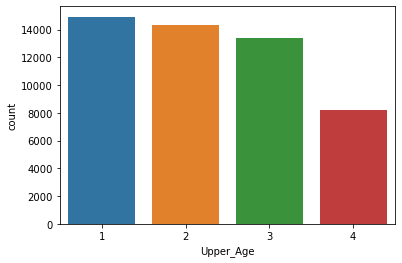

In [198]:
sns.countplot(df4.Upper_Age.astype('category'))

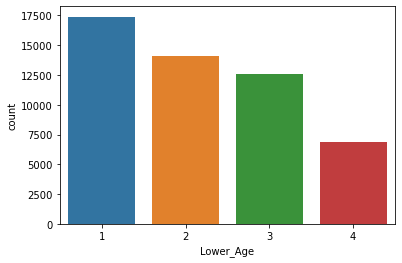

In [199]:
sns.countplot(df4.Lower_Age.astype('category'))

In [200]:
df4.Upper_Age = df4.Upper_Age.astype('category')
df4.Lower_Age = df4.Lower_Age.astype('category')

In [201]:
df4.pivot_table(index='Upper_Age', values='Reco_Policy_Premium')

,Reco_Policy_Premium
Upper_Age,
1,8022.816674
2,12689.950125
3,17681.921997
4,22305.368879


In [202]:
df4[['Upper_Age', 'Reco_Policy_Premium']].astype(int).corr()

,Upper_Age,Reco_Policy_Premium
Upper_Age,1.000000,0.767585
Reco_Policy_Premium,0.767585,1.000000


In [203]:
def bin_premium(x):
    if x<8022.816674:
        return 1
    elif x<12689.950125:
        return 2
    elif x<17681.921997:
        return 3
    else:
        return 4

In [204]:
df4.Reco_Policy_Premium = df4.Reco_Policy_Premium.apply(bin_premium)

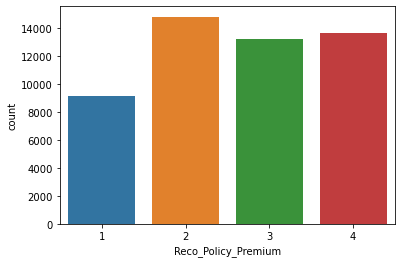

In [205]:
sns.countplot(df4.Reco_Policy_Premium.astype('category'))

### Model Building

In [236]:
x = df4.drop('Response', axis=1)
y = df4.Response

trainx, testx, trainy, testy = train_test_split(x, y, stratify=y, test_size=0.30, random_state=441)

In [237]:
trainx = trainx.astype('int')
testx = testx.astype('int')

Training Score = 0.7600583990790915
Testing Score = 0.7600393056010482
Cross Validation Score = 0.7600584003090637
ROC-AUC Score = 0.567308332607419


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.76      1.00      0.86     11602
           1       0.00      0.00      0.00      3663

    accuracy                           0.76     15265
   macro avg       0.38      0.50      0.43     15265
weighted avg       0.58      0.76      0.66     15265



-----------ROC AUC CURVE-----------



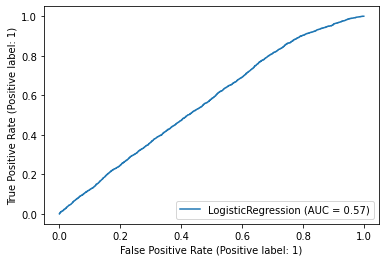



-----------CONFUSION MATRIX-----------



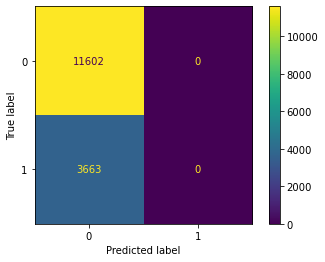

LogisticRegression(random_state=441)

In [238]:
lr = LogisticRegression(random_state=seed)
report(lr, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.770980149928405
Testing Score = 0.7524402227317393
Cross Validation Score = 0.7531516594234161
ROC-AUC Score = 0.6281090488554718


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.77      0.95      0.85     11602
           1       0.44      0.11      0.18      3663

    accuracy                           0.75     15265
   macro avg       0.61      0.53      0.52     15265
weighted avg       0.69      0.75      0.69     15265



-----------ROC AUC CURVE-----------



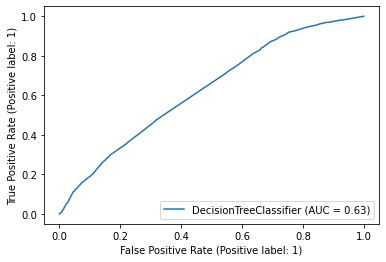



-----------CONFUSION MATRIX-----------



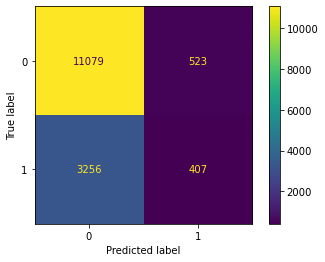

DecisionTreeClassifier(max_depth=10)

In [239]:
dtc = DecisionTreeClassifier(max_depth=10)
report(dtc,trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.7692113316674621
Testing Score = 0.7597117589256469
Cross Validation Score = 0.7598899319670729
ROC-AUC Score = 0.6065255089130283


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.76      1.00      0.86     11602
           1       0.33      0.00      0.00      3663

    accuracy                           0.76     15265
   macro avg       0.55      0.50      0.43     15265
weighted avg       0.66      0.76      0.66     15265



-----------ROC AUC CURVE-----------



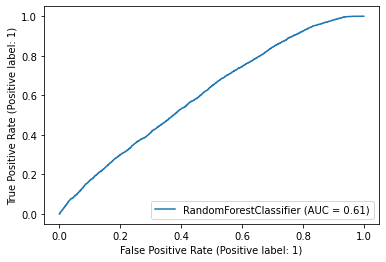



-----------CONFUSION MATRIX-----------



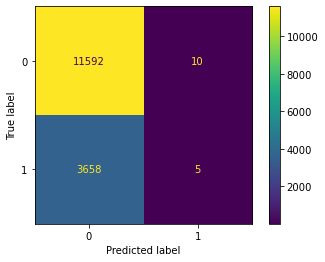

RandomForestClassifier(max_depth=18)

In [240]:
rf = RandomForestClassifier(max_depth=18)
report(rf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

[20:17:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score = 0.7850745430552826
Testing Score = 0.7561742548313135
[20:17:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

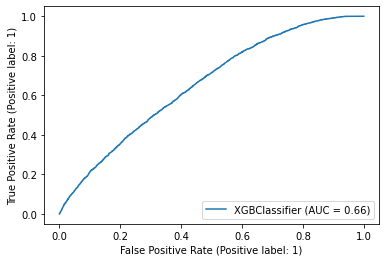



-----------CONFUSION MATRIX-----------



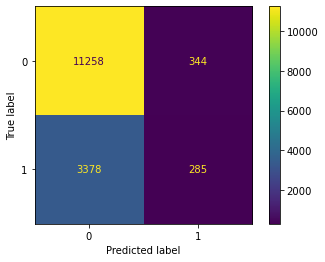

In [241]:
xgbclf = xgb.XGBClassifier(random_state=seed)
xgbclf = report(xgbclf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.9364348485273886
Testing Score = 0.7125450376678677
Cross Validation Score = 0.719263029042186
ROC-AUC Score = 0.6011831321691691


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.77      0.88      0.82     11602
           1       0.33      0.19      0.24      3663

    accuracy                           0.71     15265
   macro avg       0.55      0.53      0.53     15265
weighted avg       0.67      0.71      0.68     15265



-----------ROC AUC CURVE-----------



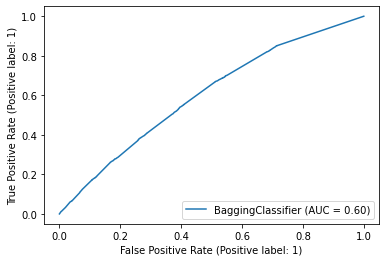



-----------CONFUSION MATRIX-----------



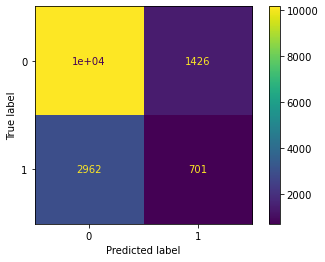

BaggingClassifier(random_state=441)

In [242]:
bg = BaggingClassifier(n_estimators=10, random_state=seed)
report(bg, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

## Oversampling V4

In [243]:
ovrs = SMOTE(random_state=seed)
trainx, trainy = ovrs.fit_resample(trainx, trainy)
testx, testy = ovrs.fit_resample(testx, testy)

Training Score = 0.7347530567766244
Testing Score = 0.7686174797448716
Cross Validation Score = 0.7339461896548565
ROC-AUC Score = 0.8224882227743042


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.70      0.93      0.80     11602
           1       0.90      0.60      0.72     11602

    accuracy                           0.77     23204
   macro avg       0.80      0.77      0.76     23204
weighted avg       0.80      0.77      0.76     23204



-----------ROC AUC CURVE-----------



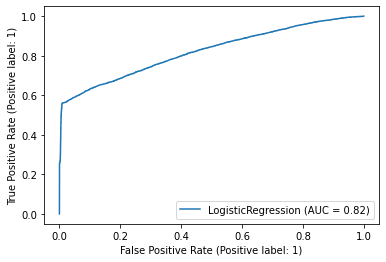



-----------CONFUSION MATRIX-----------



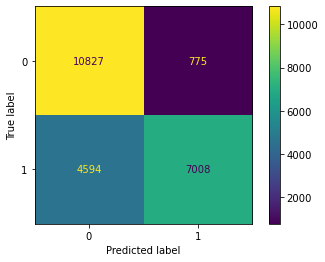

LogisticRegression(random_state=441)

In [244]:
lr = LogisticRegression(random_state=seed)
report(lr, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.6479258246832403
Testing Score = 0.6264437166005861
Cross Validation Score = 0.6298824988777586
ROC-AUC Score = 0.6746990767244626


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.67      0.50      0.57     11602
           1       0.60      0.75      0.67     11602

    accuracy                           0.63     23204
   macro avg       0.63      0.63      0.62     23204
weighted avg       0.63      0.63      0.62     23204



-----------ROC AUC CURVE-----------



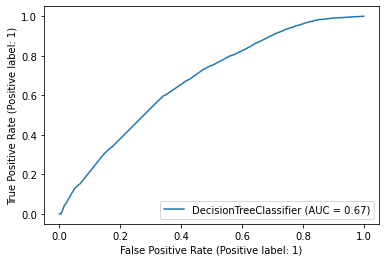



-----------CONFUSION MATRIX-----------



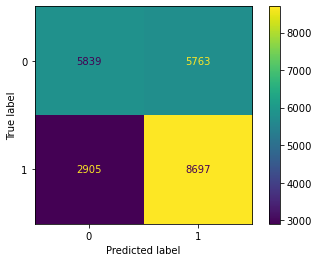

DecisionTreeClassifier(max_depth=10)

In [245]:
dtc = DecisionTreeClassifier(max_depth=10)
report(dtc,trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.8861881718444091
Testing Score = 0.716428202034132
Cross Validation Score = 0.7510101792983397
ROC-AUC Score = 0.8033508420594908


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.71      0.73      0.72     11602
           1       0.72      0.71      0.71     11602

    accuracy                           0.72     23204
   macro avg       0.72      0.72      0.72     23204
weighted avg       0.72      0.72      0.72     23204



-----------ROC AUC CURVE-----------



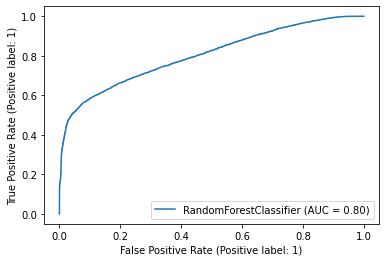



-----------CONFUSION MATRIX-----------



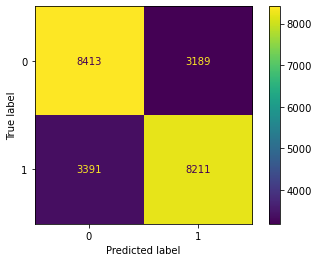

RandomForestClassifier(max_depth=18)

In [246]:
rf = RandomForestClassifier(max_depth=18)
report(rf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

[20:18:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score = 0.7958516493664808
Testing Score = 0.765988622651267
[20:18:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:18:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


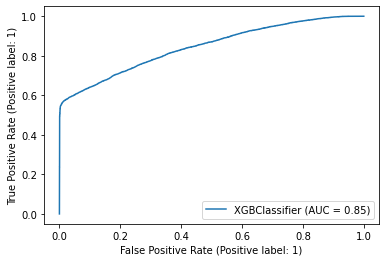



-----------CONFUSION MATRIX-----------



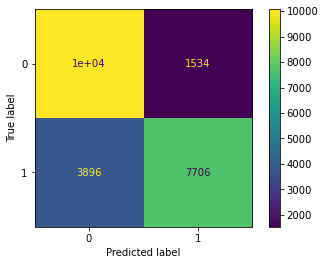

In [247]:
xgbclf = xgb.XGBClassifier(random_state=seed, )
xgbclf = report(xgbclf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.9463817369140408
Testing Score = 0.740820548181348
Cross Validation Score = 0.7845338880060564
ROC-AUC Score = 0.8013996124582602


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.71      0.82      0.76     11602
           1       0.78      0.67      0.72     11602

    accuracy                           0.74     23204
   macro avg       0.75      0.74      0.74     23204
weighted avg       0.75      0.74      0.74     23204



-----------ROC AUC CURVE-----------



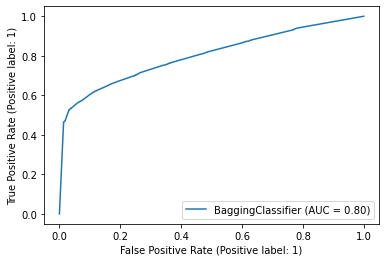



-----------CONFUSION MATRIX-----------



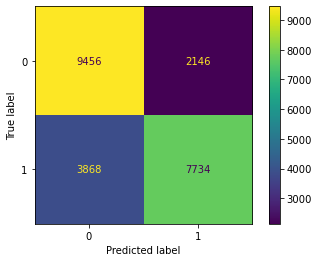

BaggingClassifier(random_state=441)

In [248]:
bg = BaggingClassifier(n_estimators=10, random_state=seed)
report(bg, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.7455764471205348
Testing Score = 0.7791760041372178
ROC-AUC Score = 0.8280416509752389


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.70      0.97      0.82     11602
           1       0.96      0.58      0.73     11602

    accuracy                           0.78     23204
   macro avg       0.83      0.78      0.77     23204
weighted avg       0.83      0.78      0.77     23204



-----------ROC AUC CURVE-----------



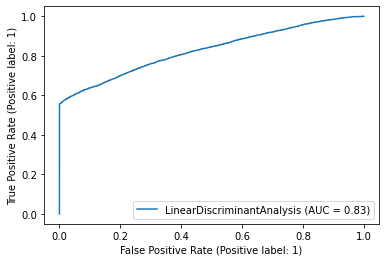



-----------CONFUSION MATRIX-----------



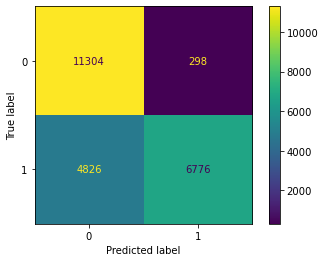

In [249]:
lda = LinearDiscriminantAnalysis()
lda = report(lda, trainx=trainx, trainy=trainy, testx=testx, testy=testy)

In [250]:
save(lda, '4lda')

'Models/model_4lda.pkl'

# <center> VERSION 5 </center>

In [1936]:
df5 = df2.copy()

In [1937]:
df5.head()

,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,...,C33,C34,C35,C36,C4,C5,C6,C7,C8,C9
0,0,0,36,36,0,15,3.0,22,11628.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,75,22,0,0,0.0,22,30510.0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,32,32,0,1,1.0,19,7450.0,1,...,0,0,0,0,0,1,0,0,0,0
3,1,1,52,48,0,15,3.0,19,17780.0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,44,44,0,3,1.0,16,10404.0,0,...,0,0,0,0,0,0,0,0,1,0


In [1938]:
temp = df5[['Upper_Age', 'Lower_Age', 'Holding_Policy_Duration', 'Reco_Policy_Premium']]
temp.head()

,Upper_Age,Lower_Age,Holding_Policy_Duration,Reco_Policy_Premium
0,36,36,15,11628.0
1,75,22,0,30510.0
2,32,32,1,7450.0
3,52,48,15,17780.0
4,44,44,3,10404.0


In [1939]:
pca = PCA(random_state=seed, n_components=1)
pca.fit(temp)

PCA(n_components=1, random_state=441)

In [1940]:
pca.explained_variance_ratio_

array([0.99999267])

In [1941]:
save(pca, 'pca5', 1)

'Resources/pca5.pkl'

In [1942]:
ulhr = pca.transform(temp)
ulhr

array([[-2555.96811028],
       [16326.02123723],
       [-6733.97121998],
       ...,
       [-2809.86731065],
       [13995.26517409],
       [-2760.01451885]])

In [1943]:
df5 = df5.drop(['Upper_Age', 'Lower_Age', 'Holding_Policy_Duration', 'Reco_Policy_Premium'], axis=1)

In [1944]:
df5['ulhr'] = ulhr

### Model Building

In [1945]:
x = df5.drop('Response', axis=1)
y = df5.Response

trainx, testx, trainy, testy = train_test_split(x, y, stratify=y, test_size=0.30, random_state=441)

In [1946]:
trainx = trainx.astype('int')
testx = testx.astype('int')

Training Score = 0.7600583990790915
Testing Score = 0.7600393056010482
Cross Validation Score = 0.7600584003090637
ROC-AUC Score = 0.5376932502859068


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.76      1.00      0.86     11602
           1       0.00      0.00      0.00      3663

    accuracy                           0.76     15265
   macro avg       0.38      0.50      0.43     15265
weighted avg       0.58      0.76      0.66     15265



-----------ROC AUC CURVE-----------



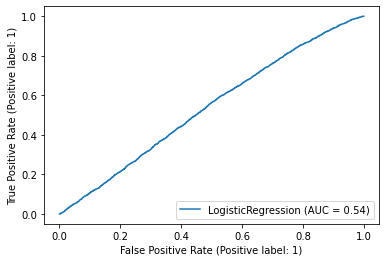



-----------CONFUSION MATRIX-----------



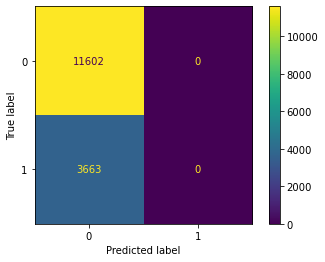

LogisticRegression(random_state=441)

In [1947]:
lr = LogisticRegression(random_state=seed)
report(lr, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.7720470561810372
Testing Score = 0.7556501801506714
Cross Validation Score = 0.7528989332624314
ROC-AUC Score = 0.6303411119822083


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.77      0.96      0.86     11602
           1       0.46      0.09      0.16      3663

    accuracy                           0.76     15265
   macro avg       0.61      0.53      0.51     15265
weighted avg       0.70      0.76      0.69     15265



-----------ROC AUC CURVE-----------



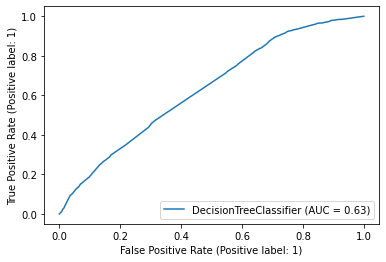



-----------CONFUSION MATRIX-----------



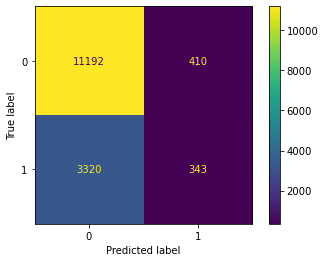

DecisionTreeClassifier(max_depth=10)

In [1948]:
dtc = DecisionTreeClassifier(max_depth=10)
report(dtc,trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.7697728612741107
Testing Score = 0.7596462495905667
Cross Validation Score = 0.7598056977960774
ROC-AUC Score = 0.6178198186903583


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.76      1.00      0.86     11602
           1       0.43      0.01      0.01      3663

    accuracy                           0.76     15265
   macro avg       0.60      0.50      0.44     15265
weighted avg       0.68      0.76      0.66     15265



-----------ROC AUC CURVE-----------



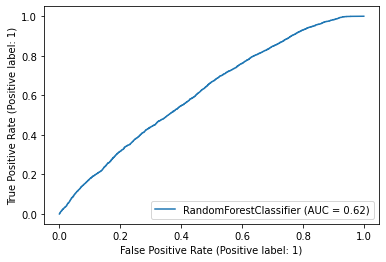



-----------CONFUSION MATRIX-----------



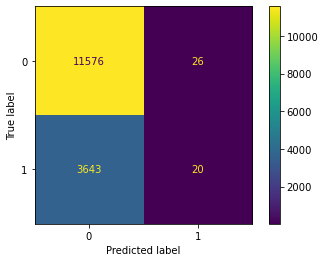

RandomForestClassifier(max_depth=18)

In [263]:
rf = RandomForestClassifier(max_depth=18)
report(rf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

[09:37:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score = 0.7833618777550047
Testing Score = 0.7550605961349492
[09:37:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:37:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

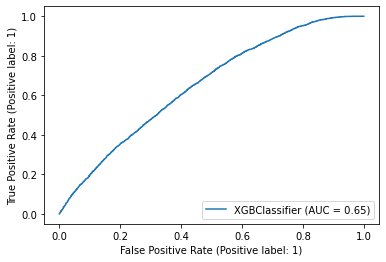



-----------CONFUSION MATRIX-----------



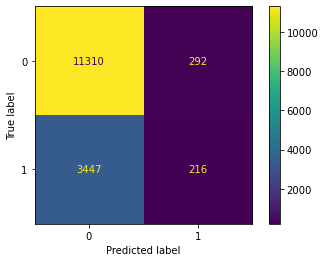

In [1949]:
xgbclf = xgb.XGBClassifier(random_state=seed)
xgbclf = report(xgbclf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.9722323609512311
Testing Score = 0.7209957418932198
Cross Validation Score = 0.7217900068760498
ROC-AUC Score = 0.6004829601192297


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.77      0.89      0.83     11602
           1       0.34      0.18      0.23      3663

    accuracy                           0.72     15265
   macro avg       0.56      0.53      0.53     15265
weighted avg       0.67      0.72      0.69     15265



-----------ROC AUC CURVE-----------



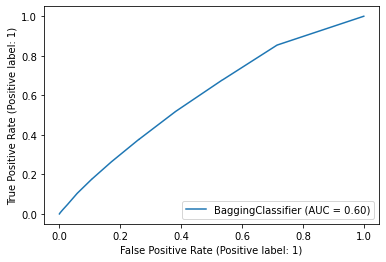



-----------CONFUSION MATRIX-----------



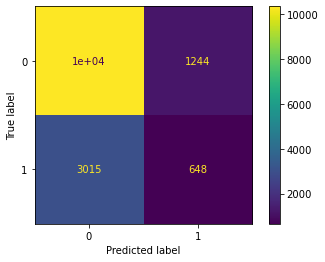

BaggingClassifier(random_state=441)

In [265]:
bg = BaggingClassifier(n_estimators=10, random_state=seed)
report(bg, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

## Oversampling V5

In [1951]:
ovrs = SMOTE(random_state=seed)
trainx, trainy = ovrs.fit_resample(trainx, trainy)
testx, testy = ovrs.fit_resample(testx, testy)

Training Score = 0.7964611576964279
Testing Score = 0.7974918117565937
Cross Validation Score = 0.7395421156158182
ROC-AUC Score = 0.8381523697787812


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.75      0.90      0.82     11602
           1       0.88      0.69      0.77     11602

    accuracy                           0.80     23204
   macro avg       0.81      0.80      0.80     23204
weighted avg       0.81      0.80      0.80     23204



-----------ROC AUC CURVE-----------



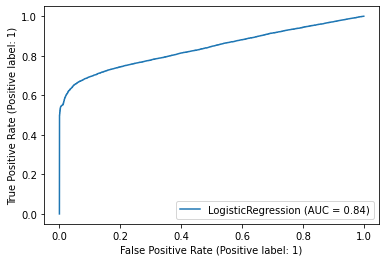



-----------CONFUSION MATRIX-----------



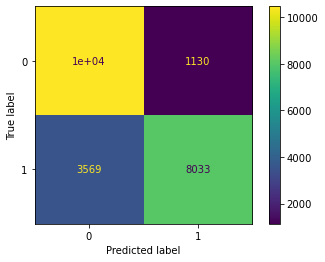

LogisticRegression(random_state=441)

In [267]:
lr = LogisticRegression(random_state=seed)
report(lr, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.7799859628384618
Testing Score = 0.762971901396311
Cross Validation Score = 0.7613931577575477
ROC-AUC Score = 0.8308437204815309


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.69      0.95      0.80     11602
           1       0.92      0.58      0.71     11602

    accuracy                           0.76     23204
   macro avg       0.81      0.76      0.75     23204
weighted avg       0.81      0.76      0.75     23204



-----------ROC AUC CURVE-----------



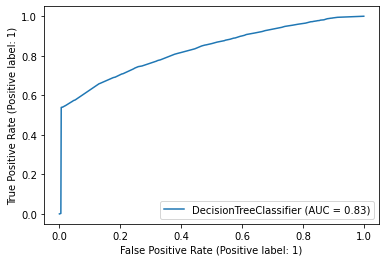



-----------CONFUSION MATRIX-----------



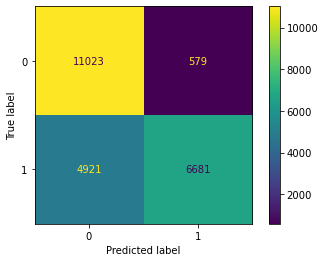

DecisionTreeClassifier(max_depth=10)

In [268]:
dtc = DecisionTreeClassifier(max_depth=10)
report(dtc,trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.8867422703261794
Testing Score = 0.7882261679020859
Cross Validation Score = 0.7848689605136476
ROC-AUC Score = 0.848906872959774


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.72      0.93      0.81     11602
           1       0.90      0.65      0.75     11602

    accuracy                           0.79     23204
   macro avg       0.81      0.79      0.78     23204
weighted avg       0.81      0.79      0.78     23204



-----------ROC AUC CURVE-----------



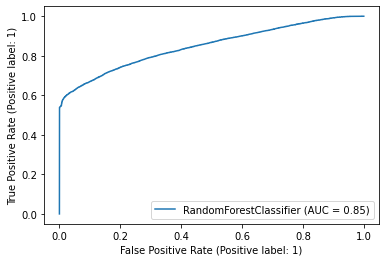



-----------CONFUSION MATRIX-----------



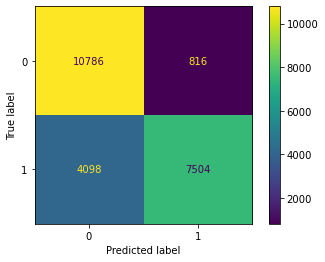

RandomForestClassifier(max_depth=18)

In [269]:
rf = RandomForestClassifier(max_depth=18)
report(rf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.9825089579254553
Testing Score = 0.7886140320634374
Cross Validation Score = 0.7880268841929088
ROC-AUC Score = 0.84699465710413


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.75      0.87      0.80     11602
           1       0.84      0.71      0.77     11602

    accuracy                           0.79     23204
   macro avg       0.80      0.79      0.79     23204
weighted avg       0.80      0.79      0.79     23204



-----------ROC AUC CURVE-----------



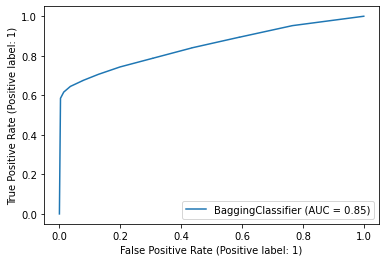



-----------CONFUSION MATRIX-----------



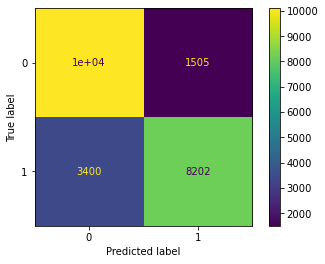

BaggingClassifier(random_state=441)

In [271]:
bg = BaggingClassifier(n_estimators=10, random_state=seed)
report(bg, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

[09:38:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score = 0.8574858704887148
Testing Score = 0.8299000172384071
[09:38:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:38:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

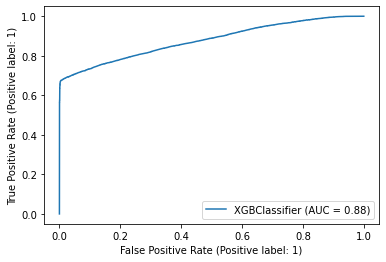



-----------CONFUSION MATRIX-----------



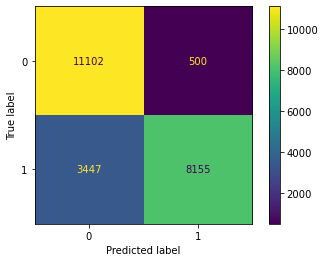

In [1952]:
xgbclf = xgb.XGBClassifier(random_state=seed, )
xgbclf = report(xgbclf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.8325329688596653
Testing Score = 0.8337355628339942
Cross Validation Score = 0.833391139411634
ROC-AUC Score = 0.8564046217295873


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.75      1.00      0.86     11602
           1       1.00      0.67      0.80     11602

    accuracy                           0.83     23204
   macro avg       0.88      0.83      0.83     23204
weighted avg       0.88      0.83      0.83     23204



-----------ROC AUC CURVE-----------



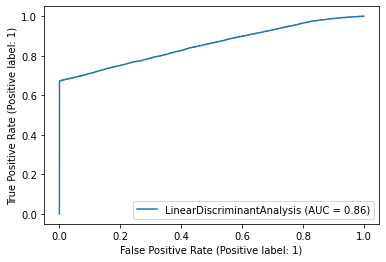



-----------CONFUSION MATRIX-----------



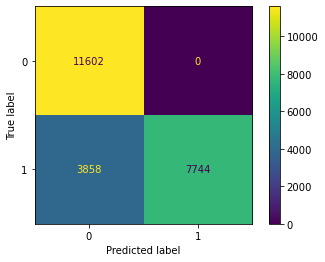

In [273]:
lda = LinearDiscriminantAnalysis()
lda = report(lda, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

In [1953]:
save(xgbclf, '5xgb1')

'Models/model_5xgb1.pkl'

# <center> VERSION 6 - Discarded due to wrong implementation of PCA <center>

In [285]:
df6 = df2.copy()

In [289]:
tt = pd.read_csv('testfortrain', index_col='Unnamed: 0')

In [298]:
temp = pd.concat([df6, tt], axis=0)

In [301]:
temp = temp[['Upper_Age', 'Lower_Age', 'Holding_Policy_Duration', 'Reco_Policy_Premium']]
temp.head()

,Upper_Age,Lower_Age,Holding_Policy_Duration,Reco_Policy_Premium
0,36,36,15,11628.0
1,75,22,0,30510.0
2,32,32,1,7450.0
3,52,48,15,17780.0
4,44,44,3,10404.0


In [327]:
# DATA LEAKAGE

pca = PCA(random_state=seed, n_components=1)
pca.fit(temp)

PCA(n_components=1, random_state=441)

In [307]:
pca.explained_variance_ratio_

array([0.99999259])

In [324]:
save(pca, 'pca6', 1)

'Resources/pca6.pkl'

In [309]:
t = df6[['Upper_Age', 'Lower_Age', 'Holding_Policy_Duration', 'Reco_Policy_Premium']]
t.head()

,Upper_Age,Lower_Age,Holding_Policy_Duration,Reco_Policy_Premium
0,36,36,15,11628.0
1,75,22,0,30510.0
2,32,32,1,7450.0
3,52,48,15,17780.0
4,44,44,3,10404.0


In [310]:
ulhr = pca.transform(t)
ulhr

array([[-2566.86125571],
       [16315.12812446],
       [-6744.86435337],
       ...,
       [-2820.76037666],
       [13984.37203846],
       [-2770.90770072]])

In [311]:
df6 = df6.drop(['Upper_Age', 'Lower_Age', 'Holding_Policy_Duration', 'Reco_Policy_Premium'], axis=1)

In [312]:
df6['ulhr'] = ulhr

### Model Building

In [313]:
x = df6.drop('Response', axis=1)
y = df6.Response

trainx, testx, trainy, testy = train_test_split(x, y, stratify=y, test_size=0.30, random_state=441)

In [314]:
trainx = trainx.astype('int')
testx = testx.astype('int')

## Oversampling V6

In [315]:
ovrs = SMOTE(random_state=seed)
trainx, trainy = ovrs.fit_resample(trainx, trainy)
testx, testy = ovrs.fit_resample(testx, testy)

Training Score = 0.7697720808244986
Testing Score = 0.7694794001034304
Cross Validation Score = 0.7453056434986258
ROC-AUC Score = 0.824630323680588


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.73      0.84      0.79     11602
           1       0.82      0.69      0.75     11602

    accuracy                           0.77     23204
   macro avg       0.78      0.77      0.77     23204
weighted avg       0.78      0.77      0.77     23204



-----------ROC AUC CURVE-----------



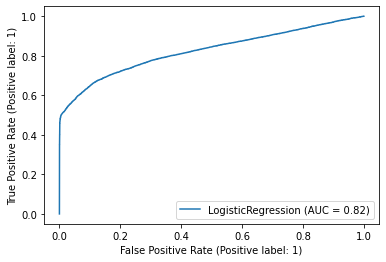



-----------CONFUSION MATRIX-----------



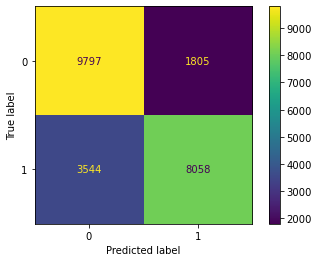

LogisticRegression(random_state=441)

In [316]:
lr = LogisticRegression(random_state=seed)
report(lr, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.7791363451664143
Testing Score = 0.7625409412170315
Cross Validation Score = 0.7621134492841211
ROC-AUC Score = 0.8311962668581503


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.69      0.95      0.80     11602
           1       0.92      0.57      0.71     11602

    accuracy                           0.76     23204
   macro avg       0.81      0.76      0.75     23204
weighted avg       0.81      0.76      0.75     23204



-----------ROC AUC CURVE-----------



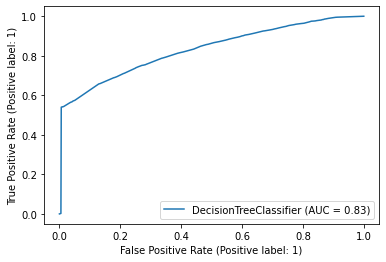



-----------CONFUSION MATRIX-----------



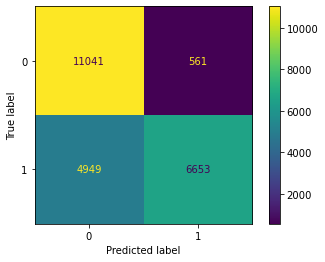

DecisionTreeClassifier(max_depth=10)

In [317]:
dtc = DecisionTreeClassifier(max_depth=10)
report(dtc,trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.8852092645266152
Testing Score = 0.7885709360455094
Cross Validation Score = 0.784037715566463
ROC-AUC Score = 0.8501920235533519


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.73      0.93      0.81     11602
           1       0.90      0.65      0.75     11602

    accuracy                           0.79     23204
   macro avg       0.81      0.79      0.78     23204
weighted avg       0.81      0.79      0.78     23204



-----------ROC AUC CURVE-----------



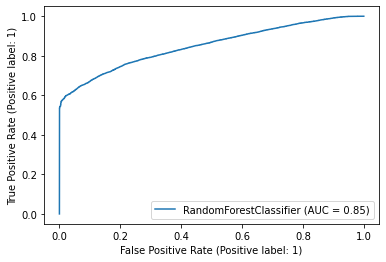



-----------CONFUSION MATRIX-----------



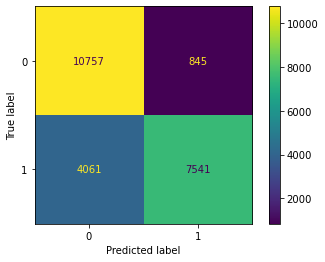

RandomForestClassifier(max_depth=18)

In [318]:
rf = RandomForestClassifier(max_depth=18)
report(rf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.9822688485833548
Testing Score = 0.7890449922427167
Cross Validation Score = 0.7882670177559246
ROC-AUC Score = 0.8454383009890079


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.75      0.87      0.80     11602
           1       0.84      0.71      0.77     11602

    accuracy                           0.79     23204
   macro avg       0.80      0.79      0.79     23204
weighted avg       0.80      0.79      0.79     23204



-----------ROC AUC CURVE-----------



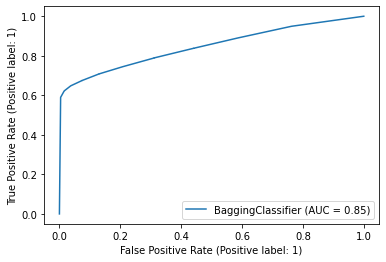



-----------CONFUSION MATRIX-----------



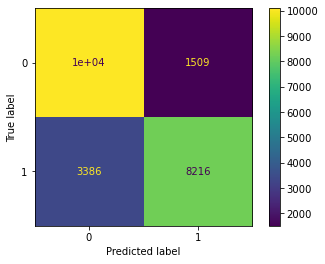

BaggingClassifier(random_state=441)

In [319]:
bg = BaggingClassifier(n_estimators=10, random_state=seed)
report(bg, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

[20:53:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score = 0.8586864171992169
Testing Score = 0.829253576969488
[20:53:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:53:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


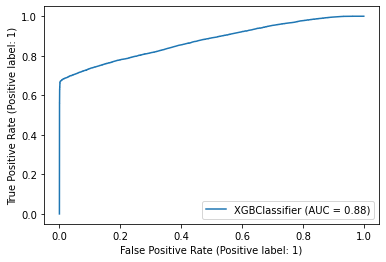



-----------CONFUSION MATRIX-----------



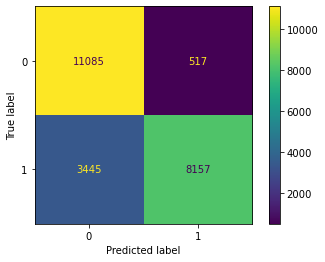

In [320]:
xgbclf = xgb.XGBClassifier(random_state=seed, )
xgbclf = report(xgbclf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.8324775590114883
Testing Score = 0.8333907946905706
Cross Validation Score = 0.8333172568848516
ROC-AUC Score = 0.8562807866110144


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.75      1.00      0.86     11602
           1       1.00      0.67      0.80     11602

    accuracy                           0.83     23204
   macro avg       0.88      0.83      0.83     23204
weighted avg       0.88      0.83      0.83     23204



-----------ROC AUC CURVE-----------



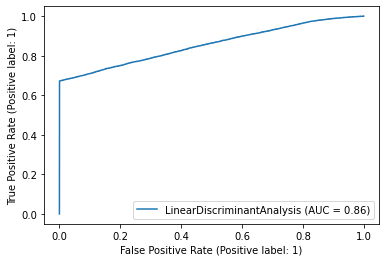



-----------CONFUSION MATRIX-----------



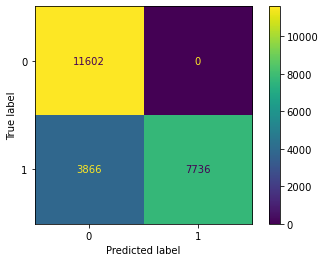

In [321]:
lda = LinearDiscriminantAnalysis()
lda = report(lda, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

In [322]:
save(lda, '6lda')

'Models/model_6lda.pkl'

In [326]:
save(xgbclf, '6xgb')

'Models/model_6xgb.pkl'

# <center>VERSION 7<center>

In [611]:
df7 = df2.copy()

In [612]:
df7.head()

,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,...,C33,C34,C35,C36,C4,C5,C6,C7,C8,C9
0,0,0,36,36,0,15,3.0,22,11628.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,75,22,0,0,0.0,22,30510.0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,32,32,0,1,1.0,19,7450.0,1,...,0,0,0,0,0,1,0,0,0,0
3,1,1,52,48,0,15,3.0,19,17780.0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,44,44,0,3,1.0,16,10404.0,0,...,0,0,0,0,0,0,0,0,1,0


In [613]:
def bin_age(x):
    if 0<=x<=30:
        return 1 # kids
    elif (x>30) and(x<=48):
        return 2 # Young
    elif (x>48) and(x<=65):
        return 3 # old
    else:
        return 4 # Very old

In [614]:
df7.Upper_Age = df7.Upper_Age.apply(bin_age)

In [615]:
df7.Lower_Age = df7.Lower_Age.apply(bin_age)

In [616]:
df7.Reco_Policy_Premium = np.log10(df7.Reco_Policy_Premium)

## Model Building

In [617]:
x = df7.drop('Response', axis=1)
y = df7.Response

trainx, testx, trainy, testy = train_test_split(x, y, stratify=y, test_size=0.30, random_state=441)

In [618]:
trainx = trainx.astype('int')
testx = testx.astype('int')

## Oversampling V7

In [619]:
ovrs = SMOTE(random_state=seed)
trainx, trainy = ovrs.fit_resample(trainx, trainy)
testx, testy = ovrs.fit_resample(testx, testy)

Training Score = 0.7327028923940748
Testing Score = 0.7692639200137907
Cross Validation Score = 0.7306400796231084
ROC-AUC Score = 0.8235239870162493


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.70      0.93      0.80     11602
           1       0.90      0.61      0.73     11602

    accuracy                           0.77     23204
   macro avg       0.80      0.77      0.76     23204
weighted avg       0.80      0.77      0.76     23204



-----------ROC AUC CURVE-----------



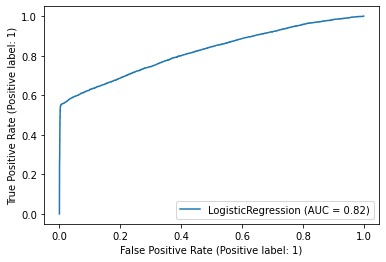



-----------CONFUSION MATRIX-----------



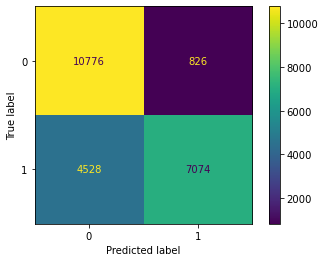

LogisticRegression(random_state=441)

In [620]:
lr = LogisticRegression(random_state=seed)
report(lr, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.6772191644194895
Testing Score = 0.660015514566454
Cross Validation Score = 0.6323202862458387
ROC-AUC Score = 0.6970494843618287


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.68      0.60      0.64     11602
           1       0.64      0.72      0.68     11602

    accuracy                           0.66     23204
   macro avg       0.66      0.66      0.66     23204
weighted avg       0.66      0.66      0.66     23204



-----------ROC AUC CURVE-----------



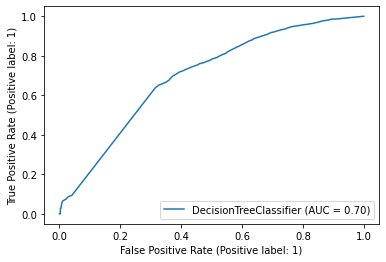



-----------CONFUSION MATRIX-----------



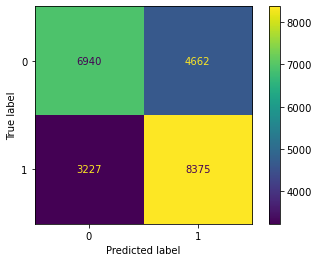

DecisionTreeClassifier(max_depth=10)

In [621]:
dtc = DecisionTreeClassifier(max_depth=10)
report(dtc,trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.8798345092534446
Testing Score = 0.7132390967074642
Cross Validation Score = 0.7481843193359865
ROC-AUC Score = 0.8023924144054839


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.71      0.72      0.72     11602
           1       0.72      0.70      0.71     11602

    accuracy                           0.71     23204
   macro avg       0.71      0.71      0.71     23204
weighted avg       0.71      0.71      0.71     23204



-----------ROC AUC CURVE-----------



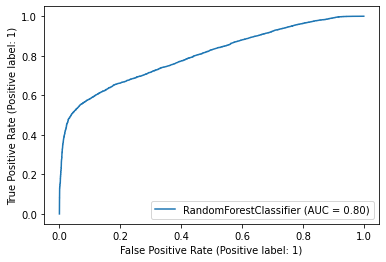



-----------CONFUSION MATRIX-----------



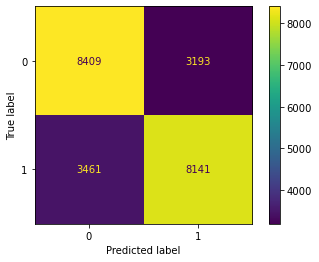

RandomForestClassifier(max_depth=18)

In [622]:
rf = RandomForestClassifier(max_depth=18)
report(rf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.9384581286247276
Testing Score = 0.7337958972590932
Cross Validation Score = 0.7812461582058301
ROC-AUC Score = 0.8034499495284042


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.70      0.80      0.75     11602
           1       0.77      0.66      0.71     11602

    accuracy                           0.73     23204
   macro avg       0.74      0.73      0.73     23204
weighted avg       0.74      0.73      0.73     23204



-----------ROC AUC CURVE-----------



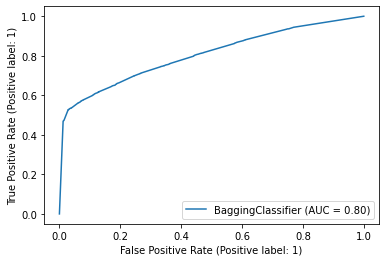



-----------CONFUSION MATRIX-----------



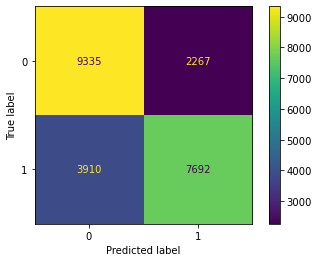

BaggingClassifier(random_state=441)

In [623]:
bg = BaggingClassifier(n_estimators=10, random_state=seed)
report(bg, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

[00:16:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score = 0.7973477152672601
Testing Score = 0.7627995173245992
[00:16:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:16:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

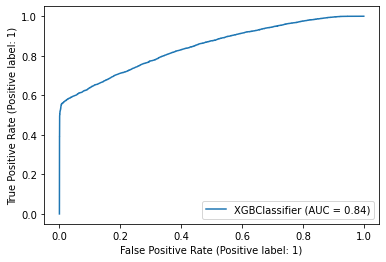



-----------CONFUSION MATRIX-----------



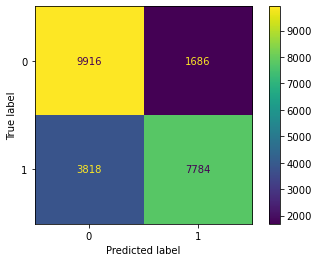

In [624]:
xgbclf = xgb.XGBClassifier(random_state=seed, )
xgbclf = report(xgbclf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.7405895607846035
Testing Score = 0.7782709877607309
Cross Validation Score = 0.7391919752755184
ROC-AUC Score = 0.8281634096695726


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.70      0.97      0.81     11602
           1       0.95      0.59      0.73     11602

    accuracy                           0.78     23204
   macro avg       0.83      0.78      0.77     23204
weighted avg       0.83      0.78      0.77     23204



-----------ROC AUC CURVE-----------



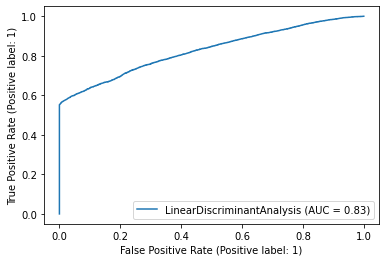



-----------CONFUSION MATRIX-----------



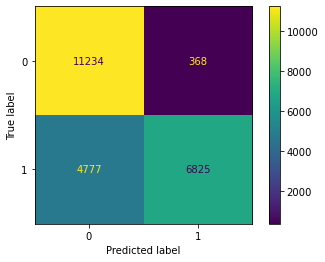

In [625]:
lda = LinearDiscriminantAnalysis()
lda = report(lda, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

In [357]:
save(lda, '7lda')

'Models/model_7lda.pkl'

In [358]:
save(xgbclf, '7xgb')

'Models/model_7xgb.pkl'

In [360]:
save(lr, '7lr')

Exception: File Exist Error.

# <center>VERSION 8 - Failed Feature Engineering (Discarded)</center>

In [1120]:
df2.Reco_Policy_Premium = np.log10(df2.Reco_Policy_Premium)

In [1121]:
df8 = df2.copy()

In [1122]:
df8.Upper_Age = df8.Upper_Age.apply(bin_age)
df8.Lower_Age = df8.Lower_Age.apply(bin_age)

In [1123]:
pca = PCA()

In [1124]:
pca.fit(df8.drop('Response', axis=1))

PCA()

In [1125]:
df8.columns.delete(9)

Index(['Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age',
       'Is_Spouse', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'X0', 'X1', 'X2', 'X3', 'X4',
       'X5', 'X6', 'X7', 'X8', 'X9', 'C1', 'C10', 'C11', 'C12', 'C13', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C2', 'C20', 'C21', 'C22', 'C23',
       'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C3', 'C30', 'C31', 'C32',
       'C33', 'C34', 'C35', 'C36', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'],
      dtype='object')

In [1126]:
pca.explained_variance_ratio_

array([5.79559308e-01, 3.41064006e-01, 2.74306009e-02, 1.86357148e-02,
       4.62630631e-03, 3.50823699e-03, 3.08122960e-03, 2.75196528e-03,
       2.31703893e-03, 2.20912788e-03, 1.78895635e-03, 1.67455953e-03,
       1.22382851e-03, 9.67933363e-04, 9.05224413e-04, 5.96279978e-04,
       5.85199808e-04, 5.42987404e-04, 5.19388116e-04, 4.77242238e-04,
       4.21566889e-04, 3.92984570e-04, 3.69958286e-04, 3.32720956e-04,
       3.24340133e-04, 3.20973260e-04, 2.93373542e-04, 2.71944582e-04,
       2.55182756e-04, 2.47796264e-04, 2.30329478e-04, 2.14543773e-04,
       1.96196018e-04, 1.92260235e-04, 1.71935443e-04, 1.59051628e-04,
       1.48896849e-04, 1.43992082e-04, 1.39748521e-04, 1.12318122e-04,
       1.05046212e-04, 8.70468116e-05, 8.21208545e-05, 8.06334554e-05,
       6.36583854e-05, 4.64800332e-05, 3.76101338e-05, 2.52984420e-05,
       1.89247102e-05, 1.71247433e-05, 1.60229479e-05, 1.04321057e-05,
       4.35346494e-06, 1.14297920e-31, 3.35943031e-33])

In [1127]:
df8.columns.delete(9)[pca.explained_variance_ratio_>0.03]

Index(['Accomodation_Type', 'Reco_Insurance_Type'], dtype='object')

In [1128]:
df8[['Response', 'Accomodation_Type']].astype(int).corr()

,Response,Accomodation_Type
Response,1.000000,0.005201
Accomodation_Type,0.005201,1.000000


In [1129]:
df8.head()

,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,...,C33,C34,C35,C36,C4,C5,C6,C7,C8,C9
0,0,0,2,2,0,15,3.0,22,4.065505,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,4,1,0,0,0.0,22,4.484442,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,2,2,0,1,1.0,19,3.872156,1,...,0,0,0,0,0,1,0,0,0,0
3,1,1,3,2,0,15,3.0,19,4.249932,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,2,2,0,3,1.0,16,4.017200,0,...,0,0,0,0,0,0,0,0,1,0


# Rented Individual

In [1130]:
Counter(df8[(df8.Accomodation_Type==0) & (df8.Reco_Insurance_Type==0)].Response)

Counter({0: 15520, 1: 4754})

In [1131]:
df8.columns

Index(['Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age',
       'Is_Spouse', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response', 'X0', 'X1', 'X2',
       'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'C1', 'C10', 'C11', 'C12',
       'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C2', 'C20', 'C21',
       'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C3', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C4', 'C5', 'C6', 'C7', 'C8',
       'C9'],
      dtype='object')

In [1132]:
temp = df8[(df8.Accomodation_Type==0) & (df8.Reco_Insurance_Type==0)].drop([ 'X0', 'X1', 'X2',\
       'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'C1', 'C10', 'C11', 'C12',\
       'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C2', 'C20', 'C21',\
       'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C3', 'C30',\
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C4', 'C5', 'C6', 'C7', 'C8',\
       'C9'], axis=1)

In [1133]:
temp = temp.astype(int)

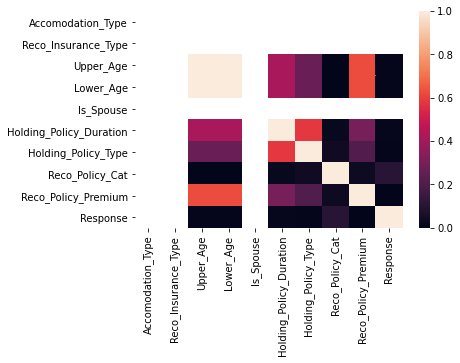

In [1134]:
sns.heatmap(temp.corr())

In [1135]:
temp[temp.Upper_Age != temp.Lower_Age]

,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response


In [1136]:
temp['city'] = df.City_Code

In [1137]:
temp = temp[['Upper_Age','Reco_Policy_Premium','Holding_Policy_Duration','Holding_Policy_Type', 'Reco_Policy_Cat','city','Response']]

In [1138]:
exl(temp[['Upper_Age','Reco_Policy_Premium','Holding_Policy_Duration','Holding_Policy_Type', 'Reco_Policy_Cat','city','Response']])

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [1139]:
temp[(temp.Upper_Age==1)].Response.value_counts()

0    8285
1    2443
Name: Response, dtype: int64

In [1140]:
temp[(temp.Upper_Age==1)& (temp.Holding_Policy_Type==0)].Response.value_counts()

0    5595
1    1641
Name: Response, dtype: int64

In [1141]:
temp[(temp.Upper_Age==1) & (temp.Reco_Policy_Premium==3)].Response.value_counts()

0    6564
1    1950
Name: Response, dtype: int64

In [1142]:
temp[(temp.Upper_Age==1) & (temp.Reco_Policy_Premium==4)].Response.value_counts()

0    1721
1     493
Name: Response, dtype: int64

In [1143]:
temp[(temp.Upper_Age==1) & (temp.Reco_Policy_Premium==3) & (temp.Holding_Policy_Type==0)].Response.value_counts()

0    4563
1    1366
Name: Response, dtype: int64

In [1144]:
temp[(temp.Upper_Age==1) & (temp.Reco_Policy_Premium==4) & (temp.Holding_Policy_Type==0)].Response.value_counts()

0    1032
1     275
Name: Response, dtype: int64

In [1145]:
temp[(temp.Upper_Age == 1) & (temp.Reco_Policy_Premium == 4) &
     (temp.Holding_Policy_Type == 0)&(temp.Reco_Policy_Cat!=1)].Response.value_counts()

0    1010
1     275
Name: Response, dtype: int64

In [1146]:
t = df.City_Code.unique()
sorted(t)

['C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C2',
 'C20',
 'C21',
 'C22',
 'C23',
 'C24',
 'C25',
 'C26',
 'C27',
 'C28',
 'C29',
 'C3',
 'C30',
 'C31',
 'C32',
 'C33',
 'C34',
 'C35',
 'C36',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9']

In [951]:
set(temp.Reco_Policy_Cat.unique())

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}

In [952]:
# CONCLUSION 1
'''
If a person living in rented apratment in city C1 recomended with Individual edition have no
spouse will not be intrested in the offer if we recommend policy category {2, 3, 4, 6, 9, 10, 11} and response will be 0
'''

for i in sorted(t):
    not_recomended = set(temp.Reco_Policy_Cat.unique()) - set(temp[(temp.city==i) & (temp.Response==1)].Reco_Policy_Cat.unique())
#     print(f'Response is 1 when person is not recomended with these policy in city {i} = {not_recomended}')
    print(f'City {i} = {not_recomended}')

City C1 = {2, 3, 4, 6, 9, 10, 11}
City C10 = {1, 4, 5, 6, 7, 8, 9, 10, 11}
City C11 = {1, 3, 7, 8, 11}
City C12 = {8, 1, 3, 11}
City C13 = {1, 3, 7, 8, 11}
City C14 = {1, 3, 4, 5, 7, 11}
City C15 = {1, 3, 4, 5, 6, 7, 9, 11}
City C16 = {1, 3, 5, 7, 11}
City C17 = {1, 3, 4, 5, 6, 7, 8, 9, 10, 11}
City C18 = {3, 5, 7, 8, 9, 10, 11, 17}
City C19 = {1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 17}
City C2 = {1, 4, 5, 6, 7, 8, 9}
City C20 = {1, 3, 11, 16, 19}
City C21 = {1, 2, 3, 4, 7, 9, 10, 11, 12, 14, 16, 19}
City C22 = {1, 2, 3, 6, 7, 10, 11, 19}
City C23 = {1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 16, 19}
City C24 = {1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 21}
City C25 = {1, 2, 3, 4, 5, 7, 8, 11, 13, 19}
City C26 = {1, 3, 4, 5, 7, 9, 10, 11, 13, 14}
City C27 = {1, 2, 3, 7, 8, 9, 11, 12, 14, 19}
City C28 = {1, 3, 4, 7, 8, 9, 10, 11, 13, 15, 17, 18}
City C29 = {1, 3, 8, 11, 18, 20}
City C3 = {11, 1, 3}
City C30 = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20}
City C31 = {1, 2, 3, 4, 5, 6,

In [953]:
len(temp)

20274

# Single Person recomended with Individual policy | Individual living in owned house

In [954]:
Counter(df8[(df8.Upper_Age==df8.Lower_Age) & (df8.Reco_Insurance_Type==0)].Is_Spouse)

Counter({0: 40536})

In [955]:
Counter(df8[(df8.Upper_Age==df8.Lower_Age) & (df8.Reco_Insurance_Type==0)].Accomodation_Type)

Counter({0: 20274, 1: 20262})

In [956]:
Counter(df8[(df8.Accomodation_Type==1) & (df8.Reco_Insurance_Type==0)].Response)

Counter({1: 4886, 0: 15376})

In [957]:
temp = df8[(df8.Accomodation_Type==1) & (df8.Reco_Insurance_Type==0)].drop([ 'X0', 'X1', 'X2',\
       'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'C1', 'C10', 'C11', 'C12',\
       'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C2', 'C20', 'C21',\
       'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C3', 'C30',\
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C4', 'C5', 'C6', 'C7', 'C8',\
       'C9'], axis=1)

In [958]:
temp[(temp.Upper_Age)!=(temp.Lower_Age)]

,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response


In [959]:
temp = temp.astype(int)

In [960]:
temp['city'] = df.City_Code

In [961]:
temp = temp[['Upper_Age','Reco_Policy_Premium','Holding_Policy_Duration','Holding_Policy_Type', 'Reco_Policy_Cat','city','Response']]

In [962]:
exl(temp[['Upper_Age','Reco_Policy_Premium','Holding_Policy_Duration','Holding_Policy_Type', 'Reco_Policy_Cat','city','Response']])

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [963]:
t = df.City_Code.unique()

In [964]:
set(temp.Reco_Policy_Cat.unique())

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}

In [965]:
# CONCLUSION 2
'''
If a person living in owned apratment in city C1 recomended with Individual edition have no
spouse will not be intrested in the offer if we recommend policy category {2, 3, 4, 6, 9, 10, 11} and response will be 0
'''

for i in sorted(t):
    not_recomended = set(temp.Reco_Policy_Cat.unique()) - set(temp[(temp.city==i) & (temp.Response==1)].Reco_Policy_Cat.unique())
#     print(f'Response is 1 when person is not recomended with these policy in city {i} = {not_recomended}')
    print(f'City {i} = {not_recomended}')

City C1 = {2, 3, 4, 6, 9, 10, 11}
City C10 = {1, 2, 4, 5, 6, 7, 8, 9, 10}
City C11 = {1, 3, 4, 7, 8, 11}
City C12 = {1, 3, 5, 6, 7, 11}
City C13 = {1, 3, 4, 7, 11}
City C14 = {1, 3, 4, 7, 10, 11}
City C15 = {1, 3, 4, 6, 7, 9, 10, 11, 13}
City C16 = {1, 3, 6, 7, 9, 11}
City C17 = {1, 3, 4, 5, 7, 8, 9, 11}
City C18 = {3, 4, 5, 6, 7, 8, 11, 14, 18}
City C19 = {1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14}
City C2 = {1, 4, 5, 6, 7, 8, 9, 10}
City C20 = {1, 2, 3, 7, 10, 11, 16, 19, 20}
City C21 = {1, 2, 3, 4, 7, 11, 12, 16, 19}
City C22 = {1, 2, 3, 7, 8, 10, 11, 13, 15, 19}
City C23 = {1, 2, 3, 5, 7, 8, 11, 12, 15, 16, 19}
City C24 = {1, 3, 4, 5, 7, 8, 9, 10, 11, 13, 21}
City C25 = {1, 2, 3, 4, 5, 7, 9, 10, 11, 16, 19}
City C26 = {1, 3, 4, 5, 7, 8, 9, 10, 11, 20}
City C27 = {1, 2, 3, 4, 8, 11, 12, 16, 19}
City C28 = {3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17}
City C29 = {1, 2, 3, 5, 8, 10, 11, 12, 13, 15, 16, 19}
City C3 = {11, 1, 3}
City C30 = {1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 17, 19, 20, 21}

# Person recommended with Individual edition (Union of above 2)

In [1147]:
temp = df8[(df8.Reco_Insurance_Type==0)].drop([ 'X0', 'X1', 'X2',\
       'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'C1', 'C10', 'C11', 'C12',\
       'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C2', 'C20', 'C21',\
       'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C3', 'C30',\
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C4', 'C5', 'C6', 'C7', 'C8',\
       'C9'], axis=1)

In [1148]:
temp[(temp.Upper_Age)!=(temp.Lower_Age)]

,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response


In [1149]:
temp.Is_Spouse.value_counts()

0    40536
1        0
Name: Is_Spouse, dtype: int64

In [1150]:
temp = temp.astype(int)

In [1151]:
temp['city'] = df.City_Code

In [1152]:
temp = temp[['Upper_Age','Reco_Policy_Premium','Holding_Policy_Duration','Holding_Policy_Type', 'Reco_Policy_Cat','city','Response']]

In [1153]:
exl(temp[['Upper_Age','Reco_Policy_Premium','Holding_Policy_Duration','Holding_Policy_Type', 'Reco_Policy_Cat','city','Response']])

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [1154]:
t = df.City_Code.unique()

In [1155]:
set(temp.Reco_Policy_Cat.unique())

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}

In [1156]:
# CONCLUSION 3
'''
If a person living in rented or owned apratment in city C1 recomended with Individual edition have no
spouse will not be intrested in the offer if we recommend policy category {2, 3, 4, 6, 9, 10, 11} and response will be 0
'''
individual_edition = {}
for i in sorted(t):
    not_recomended = set(temp.Reco_Policy_Cat.unique()) - set(temp[(temp.city==i) & (temp.Response==1)].Reco_Policy_Cat.unique())
#     print(f'Response is 1 when person is not recomended with these policy in city {i} = {not_recomended}')
    print(f'City {i} = {not_recomended}')
    individual_edition[i] = not_recomended

City C1 = {2, 3, 4, 6, 9, 10, 11}
City C10 = {1, 4, 5, 6, 7, 8, 9, 10}
City C11 = {1, 3, 7, 8, 11}
City C12 = {11, 1, 3}
City C13 = {11, 1, 3, 7}
City C14 = {1, 3, 4, 7, 11}
City C15 = {1, 3, 4, 6, 7, 9, 11}
City C16 = {11, 1, 3, 7}
City C17 = {1, 3, 4, 5, 7, 8, 9, 11}
City C18 = {3, 5, 7, 8, 11}
City C19 = {1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14}
City C2 = {1, 4, 5, 6, 7, 8, 9}
City C20 = {1, 3, 11, 16, 19}
City C21 = {1, 2, 3, 4, 7, 11, 12, 16, 19}
City C22 = {1, 2, 3, 7, 10, 11, 19}
City C23 = {1, 2, 3, 5, 7, 8, 11, 12, 16, 19}
City C24 = {1, 3, 4, 5, 7, 8, 9, 10, 11, 21}
City C25 = {1, 2, 3, 4, 5, 7, 11, 19}
City C26 = {1, 3, 4, 5, 7, 9, 10, 11}
City C27 = {1, 2, 3, 8, 11, 12, 19}
City C28 = {3, 4, 7, 8, 11, 13, 17}
City C29 = {8, 1, 3, 11}
City C3 = {11, 1, 3}
City C30 = {1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 17, 20}
City C31 = {1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}
City C32 = {1, 2, 3, 8, 10, 11, 18, 20}
City C33 = {1, 3, 4, 9, 10, 11}
City C3

In [1158]:
set(temp[(temp.city==i) & (temp.Response==1)].Reco_Policy_Cat.unique())

{2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}

In [1157]:
individual_edition['C3']

{1, 3, 11}

## Person/group recommended with Joint edition have same upper and lower age(binned)

In [976]:
temp = df8[(df8.Reco_Insurance_Type==1)].drop([ 'X0', 'X1', 'X2',\
       'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'C1', 'C10', 'C11', 'C12',\
       'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C2', 'C20', 'C21',\
       'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C3', 'C30',\
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C4', 'C5', 'C6', 'C7', 'C8',\
       'C9'], axis=1)

temp.to_csv('analysis.csv')

In [977]:
temp = temp[(temp.Upper_Age)==(temp.Lower_Age)]
temp.head()

,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
7,1,1,4,4,1,9,4.0,17,0.650066,1
30,1,1,2,2,1,3,4.0,17,0.638078,0
33,0,1,1,1,1,2,3.0,22,0.603291,0
48,1,1,3,3,1,8,4.0,17,0.648474,1
49,1,1,4,4,1,7,4.0,21,0.653305,0


In [978]:
temp = temp.astype(int)

In [979]:
temp['city'] = df.City_Code

In [980]:
temp = temp[['Upper_Age','Lower_Age','Reco_Policy_Premium','Holding_Policy_Duration','Holding_Policy_Type', 'Reco_Policy_Cat','city','Response']]

In [981]:
exl(temp[['Upper_Age','Lower_Age','Reco_Policy_Premium','Holding_Policy_Duration','Holding_Policy_Type', 'Reco_Policy_Cat','city','Response']])

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [982]:
t = df.City_Code.unique()

In [983]:
set(temp.Reco_Policy_Cat.unique())

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}

In [984]:
# CONCLUSION 4
'''
If a person living in rented or owned apratment in city C1 recomended with Join edition
will not be intrested in the offer if we recommend policy category {1, 2, 3, 4, 6, 9, 10, 11} and response will be 0
'''
join_sameage = {}
for i in sorted(t):
    not_recomended = set(temp.Reco_Policy_Cat.unique()) - set(temp[(temp.city==i) & (temp.Response==1)].Reco_Policy_Cat.unique())
#     print(f'Response is 1 when person is not recomended with these policy in city {i} = {not_recomended}')
    print(f'City {i} = {not_recomended}')
    join_sameage[i] = not_recomended    

City C1 = {1, 2, 3, 4, 6, 9, 10, 11}
City C10 = {1, 2, 4, 5, 6, 7, 8, 9, 10, 13, 14}
City C11 = {1, 3, 4, 5, 7, 8, 11, 12, 13, 14, 16}
City C12 = {1, 3, 4, 5, 7, 8, 9, 10, 11, 13, 18}
City C13 = {1, 2, 3, 5, 7, 8, 9, 11, 13, 14, 19}
City C14 = {1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16, 20}
City C15 = {1, 3, 4, 6, 7, 9, 11, 14, 16, 17, 20}
City C16 = {1, 3, 4, 7, 9, 10, 11, 14}
City C17 = {1, 3, 4, 5, 8, 9, 10, 11, 18, 21}
City C18 = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
City C19 = {1, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 18, 21}
City C2 = {1, 4, 5, 6, 7, 8, 9, 10, 20}
City C20 = {1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 16, 19, 20}
City C21 = {1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 14, 16, 18, 19}
City C22 = {1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 19}
City C23 = {1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 16, 19}
City C24 = {1, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 21}
City C25 = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 19}
City C26 = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 20, 21}
City C

In [985]:
set(temp[(temp.city=='C9') & (temp.Response==1)].Reco_Policy_Cat.unique())

{4, 5, 6, 7, 9, 10, 12, 15, 16, 17, 18, 19, 20, 21, 22}

### Person/group recommended with Joint edition do not have same upper and lower age(binned)

In [986]:
temp = df8[(df8.Reco_Insurance_Type==1)].drop([ 'X0', 'X1', 'X2',\
       'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'C1', 'C10', 'C11', 'C12',\
       'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C2', 'C20', 'C21',\
       'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C3', 'C30',\
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C4', 'C5', 'C6', 'C7', 'C8',\
       'C9'], axis=1)

temp.to_csv('analysis.csv')

In [987]:
temp = temp[(temp.Upper_Age)!=(temp.Lower_Age)]
temp.head()

,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
1,1,1,4,1,0,0,0.0,22,0.651708,0
3,1,1,3,2,0,15,3.0,19,0.628382,0
8,1,1,3,2,0,14,3.0,1,0.646981,0
9,1,1,3,1,1,7,4.0,18,0.635916,1
11,1,1,3,2,1,3,3.0,13,0.643323,0


In [988]:
temp = temp.astype(int)

In [989]:
temp['city'] = df.City_Code

In [990]:
temp = temp[['Upper_Age','Lower_Age','Reco_Policy_Premium','Holding_Policy_Duration','Holding_Policy_Type', 'Reco_Policy_Cat','city','Response']]

In [991]:
t = df.City_Code.unique()

In [992]:
set(temp.Reco_Policy_Cat.unique())

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}

In [993]:
# CONCLUSION 5
'''
If a person living in rented or owned apratment in city C1 recomended with Join edition 
will not be intrested in the offer if we recommend policy category {1, 2, 3, 4, 6, 9, 10, 11} and response will be 0
'''
join_nosameage = {}
for i in sorted(t):
    not_recomended = set(temp.Reco_Policy_Cat.unique()) - set(temp[(temp.city==i) & (temp.Response==1)].Reco_Policy_Cat.unique())
#     print(f'Response is 1 when person is not recomended with these policy in city {i} = {not_recomended}')
    print(f'City {i} = {not_recomended}')
    join_nosameage[i] = not_recomended    

City C1 = {1, 2, 3, 4, 6, 9, 10, 11}
City C10 = {1, 4, 5, 6, 7, 8, 9, 10, 15, 20, 21}
City C11 = {1, 3, 4, 5, 6, 7, 11, 12, 16, 18, 21}
City C12 = {1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 21}
City C13 = {1, 3, 5, 6, 7, 8, 9, 11, 12, 13, 18}
City C14 = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 21, 22}
City C15 = {1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 17}
City C16 = {1, 3, 5, 6, 7, 8, 9, 10, 11, 19}
City C17 = {1, 3, 4, 6, 7, 8, 9, 10, 11, 13, 21}
City C18 = {1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 18}
City C19 = {1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 17, 18}
City C2 = {1, 4, 5, 6, 7, 8, 9, 10}
City C20 = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 18, 19, 20}
City C21 = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 19}
City C22 = {1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 19, 20}
City C23 = {1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 16, 19, 22}
City C24 = {1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 19, 21}
City C25 = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 21}
City C

In [994]:
set(temp[(temp.city=='C9') & (temp.Response==1)].Reco_Policy_Cat.unique())

{4, 6, 8, 9, 10, 12, 13, 14, 17, 18, 19, 20, 21, 22}

# Implementing New features

In [1069]:
df8 = df_for_newfeatures.copy()

In [1070]:
columns = {}

In [1071]:
df8.head()

,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,0,0,36,36,0,X1,15,3.0,22,11628.0,0
1,C5,1,1,75,22,0,X2,0,0.0,22,30510.0,0
2,C5,1,0,32,32,0,NaN,1,1.0,19,7450.0,1
3,C24,1,1,52,48,0,X1,15,3.0,19,17780.0,0
4,C8,0,0,44,44,0,X2,3,1.0,16,10404.0,0


In [1072]:
df8.Reco_Policy_Cat = df8.Reco_Policy_Cat.astype('int')

In [1073]:
def create_individual_response(x):
    if( x.Reco_Insurance_Type == 0):
        reco_policy_cat = individual_edition[x.City_Code]
        if x.Reco_Policy_Cat in reco_policy_cat:
            return 0
        else:
            return 1

In [1074]:
df8['created_response'] = df8.apply(create_individual_response, axis=1)

In [1075]:
df8.head()

,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,created_response
0,C3,0,0,36,36,0,X1,15,3.0,22,11628.0,0,1.0
1,C5,1,1,75,22,0,X2,0,0.0,22,30510.0,0,NaN
2,C5,1,0,32,32,0,NaN,1,1.0,19,7450.0,1,1.0
3,C24,1,1,52,48,0,X1,15,3.0,19,17780.0,0,NaN
4,C8,0,0,44,44,0,X2,3,1.0,16,10404.0,0,1.0


In [1076]:
individual_edition['C3']

{1, 3, 11}

In [1078]:
df8.created_response.value_counts()

1.0    38802
0.0     1734
Name: created_response, dtype: int64

In [1079]:
df8.Response.value_counts()

0    38673
1    12209
Name: Response, dtype: int64

# <center>VERSION 9</center>

In [1194]:
df9 = df2.copy()

In [1195]:
df9 = df9.astype(int)

In [1196]:
df9.head()

,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,...,C33,C34,C35,C36,C4,C5,C6,C7,C8,C9
0,0,0,36,36,0,15,3,22,4,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,75,22,0,0,0,22,4,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,32,32,0,1,1,19,3,1,...,0,0,0,0,0,1,0,0,0,0
3,1,1,52,48,0,15,3,19,4,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,44,44,0,3,1,16,4,0,...,0,0,0,0,0,0,0,0,1,0


In [1197]:
(df9.Accomodation_Type+df9.Reco_Insurance_Type - df9.Is_Spouse).value_counts()

1    27345
0    22272
2     1265
dtype: int64

In [1198]:
df9['rented_indiv_nospouse_orother'] = (df9.Accomodation_Type+df9.Reco_Insurance_Type - df9.Is_Spouse)

In [1199]:
df9['is_single_person'] = df9.apply(lambda x:int(not(x.Upper_Age-x.Lower_Age)), axis=1)

In [1201]:
min_max = MinMaxScaler()

mm_ua = min_max.fit(df9.Upper_Age.values.reshape(-1, 1))
mm_la = min_max.fit(df9.Lower_Age.values.reshape(-1, 1))

df9.Upper_Age = mm_ua.transform(df9.Upper_Age.values.reshape(-1, 1))
df9.Lower_Age = mm_la.transform(df9.Lower_Age.values.reshape(-1, 1))

In [1223]:
save(mm_ua, 'mm_ua', 1)

'Resources/mm_ua.pkl'

In [1224]:
save(mm_la, 'mm_la', 1)

'Resources/mm_la.pkl'

In [1202]:
df9

,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,...,C35,C36,C4,C5,C6,C7,C8,C9,rented_indiv_nospouse_orother,is_single_person
0,0,0,0.338983,0.338983,0,15,3,22,4,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1,1.000000,0.101695,0,0,0,22,4,0,...,0,0,0,1,0,0,0,0,2,0
2,1,0,0.271186,0.271186,0,1,1,19,3,1,...,0,0,0,1,0,0,0,0,1,1
3,1,1,0.610169,0.542373,0,15,3,19,4,0,...,0,0,0,0,0,0,0,0,2,0
4,0,0,0.474576,0.474576,0,3,1,16,4,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50877,0,0,0.101695,0.101695,0,0,0,18,3,0,...,0,0,1,0,0,0,0,0,0,1
50878,0,0,0.186441,0.186441,0,7,3,4,3,0,...,0,0,0,1,0,0,0,0,0,1
50879,0,0,0.796610,0.796610,0,15,1,12,4,0,...,0,0,0,0,0,0,0,0,0,1
50880,1,1,0.932203,0.559322,0,2,2,16,4,1,...,0,0,0,0,0,0,0,0,2,0


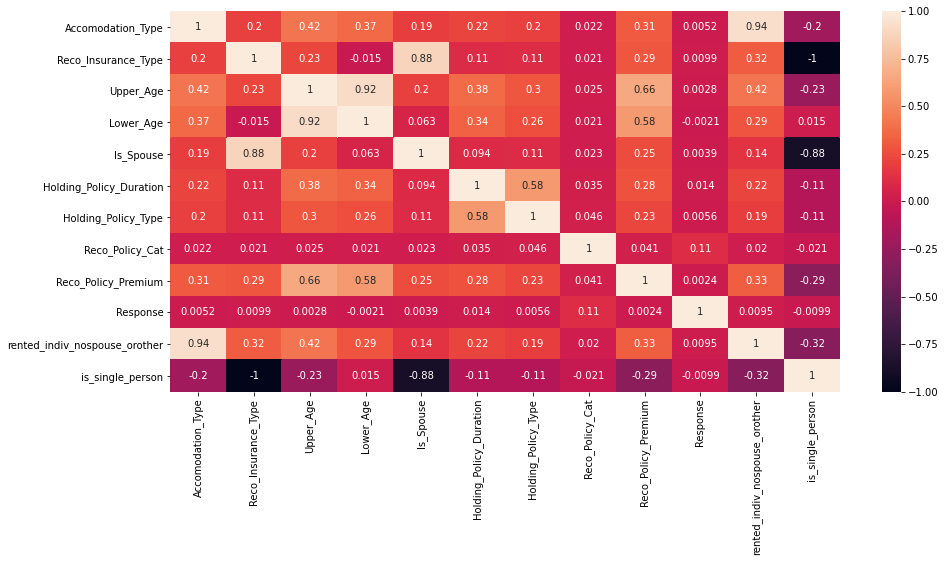

In [1206]:
plt.figure(figsize = (15, 7))
sns.heatmap(df9.drop([ 'X0', 'X1', 'X2',\
       'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'C1', 'C10', 'C11', 'C12',\
       'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C2', 'C20', 'C21',\
       'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C3', 'C30',\
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C4', 'C5', 'C6', 'C7', 'C8',\
       'C9'], axis=1).corr(), annot=True)

## Model Building

In [1207]:
x = df9.drop('Response', axis=1)
y = df9.Response

trainx, testx, trainy, testy = train_test_split(x, y, stratify=y, test_size=0.30, random_state=441)

In [1208]:
trainx = trainx.astype('int')
testx = testx.astype('int')

## Oversampling V9

In [1209]:
ovrs = SMOTE(random_state=seed)
trainx, trainy = ovrs.fit_resample(trainx, trainy)
testx, testy = ovrs.fit_resample(testx, testy)

Training Score = 0.7218795020501644
Testing Score = 0.7596535080158593
Cross Validation Score = 0.7198163099174483
ROC-AUC Score = 0.8214322403263964


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.70      0.91      0.79     11602
           1       0.87      0.61      0.72     11602

    accuracy                           0.76     23204
   macro avg       0.78      0.76      0.75     23204
weighted avg       0.78      0.76      0.75     23204



-----------ROC AUC CURVE-----------



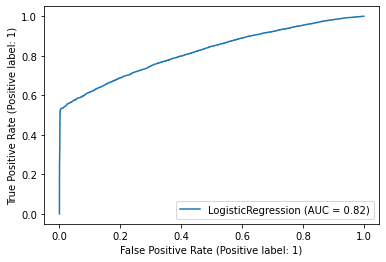



-----------CONFUSION MATRIX-----------



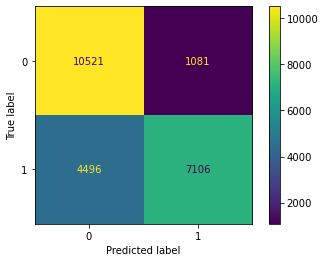

LogisticRegression(random_state=441)

In [1210]:
lr = LogisticRegression(random_state=seed)
report(lr, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.6439363156144953
Testing Score = 0.6201947940010343
Cross Validation Score = 0.6129821727787473
ROC-AUC Score = 0.6570595407927248


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.68      0.46      0.55     11602
           1       0.59      0.78      0.67     11602

    accuracy                           0.62     23204
   macro avg       0.63      0.62      0.61     23204
weighted avg       0.63      0.62      0.61     23204



-----------ROC AUC CURVE-----------



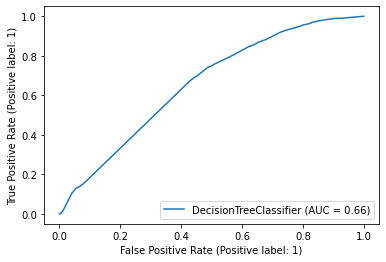



-----------CONFUSION MATRIX-----------



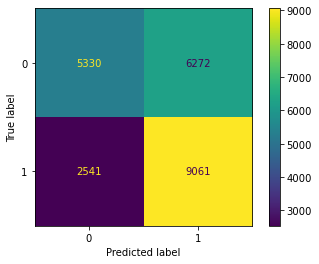

DecisionTreeClassifier(max_depth=10)

In [1211]:
dtc = DecisionTreeClassifier(max_depth=10)
report(dtc,trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.8439289276347383
Testing Score = 0.7056111015342182
Cross Validation Score = 0.7364371152683745
ROC-AUC Score = 0.8030566955789116


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.72      0.67      0.69     11602
           1       0.69      0.74      0.72     11602

    accuracy                           0.71     23204
   macro avg       0.71      0.71      0.71     23204
weighted avg       0.71      0.71      0.71     23204



-----------ROC AUC CURVE-----------



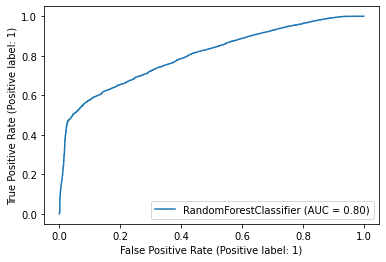



-----------CONFUSION MATRIX-----------



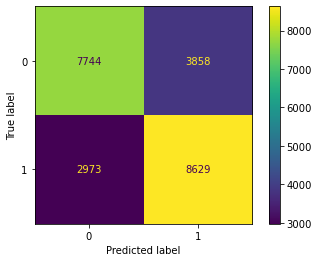

RandomForestClassifier(max_depth=18)

In [1212]:
rf = RandomForestClassifier(max_depth=18)
report(rf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.9169036976838684
Testing Score = 0.7318134804344079
Cross Validation Score = 0.7701638951735962
ROC-AUC Score = 0.7974539903762676


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.70      0.80      0.75     11602
           1       0.77      0.67      0.71     11602

    accuracy                           0.73     23204
   macro avg       0.74      0.73      0.73     23204
weighted avg       0.74      0.73      0.73     23204



-----------ROC AUC CURVE-----------



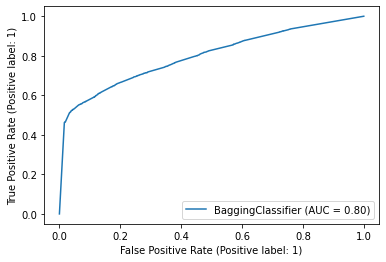



-----------CONFUSION MATRIX-----------



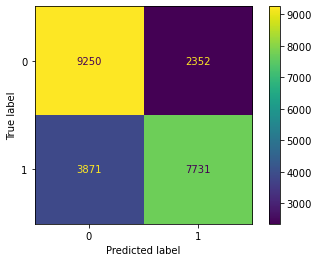

BaggingClassifier(random_state=441)

In [1213]:
bg = BaggingClassifier(n_estimators=10, random_state=seed)
report(bg, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

[05:42:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score = 0.7848989693768239
Testing Score = 0.7581020513704534
[05:42:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:42:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

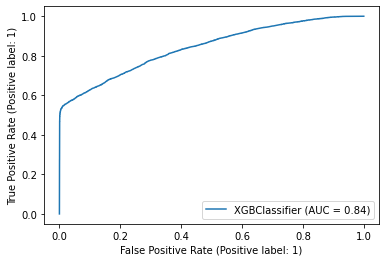



-----------CONFUSION MATRIX-----------



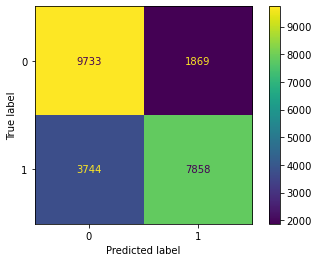

In [1214]:
xgbclf = xgb.XGBClassifier(random_state=seed, )
xgbclf = report(xgbclf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.7334601603191607
Testing Score = 0.7732287536631616
Cross Validation Score = 0.7325056662999376
ROC-AUC Score = 0.8286927418401282


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.70      0.96      0.81     11602
           1       0.93      0.59      0.72     11602

    accuracy                           0.77     23204
   macro avg       0.82      0.77      0.77     23204
weighted avg       0.82      0.77      0.77     23204



-----------ROC AUC CURVE-----------



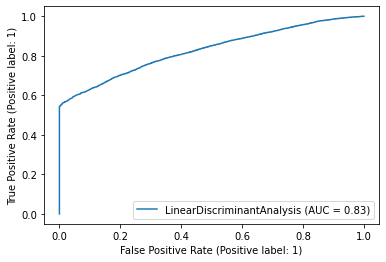



-----------CONFUSION MATRIX-----------



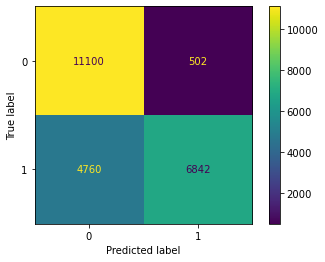

In [1215]:
lda = LinearDiscriminantAnalysis()
lda = report(lda, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

In [1216]:
save(xgbclf, 9)

'Models/model_9.pkl'

# <center>VERSION 10</center>

In [1227]:
df10 = df9.copy()

## Model Building

In [1228]:
x = df10.drop('Response', axis=1)
y = df10.Response

trainx, testx, trainy, testy = train_test_split(x, y, stratify=y, test_size=0.30, random_state=441)

In [1229]:
trainx = trainx.astype('int')
testx = testx.astype('int')

In [1247]:
pca = PCA(n_components=3)

In [1248]:
pca.fit(trainx)
trainx = pca.transform(trainx)
testx = pca.transform(testx)

In [1249]:
pca.explained_variance_ratio_

array([0.56331826, 0.37247603, 0.02022095])

In [1258]:
save(pca, 'pca', 1)

'Resources/pca.pkl'

## Oversampling V10

In [1250]:
ovrs = SMOTE(random_state=seed)
trainx, trainy = ovrs.fit_resample(trainx, trainy)
testx, testy = ovrs.fit_resample(testx, testy)

Training Score = 0.5350929038454435
Testing Score = 0.5341320461989312
Cross Validation Score = 0.5361641596196889
ROC-AUC Score = 0.5631820050701302


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.55      0.39      0.45     11602
           1       0.53      0.68      0.59     11602

    accuracy                           0.53     23204
   macro avg       0.54      0.53      0.52     23204
weighted avg       0.54      0.53      0.52     23204



-----------ROC AUC CURVE-----------



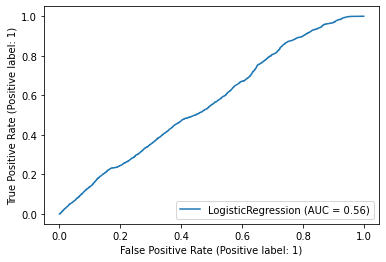



-----------CONFUSION MATRIX-----------



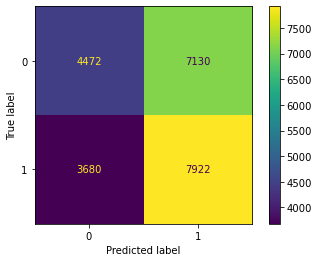

LogisticRegression(random_state=441)

In [1251]:
lr = LogisticRegression(random_state=seed)
report(lr, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.6288463669609545
Testing Score = 0.6060162041027409
Cross Validation Score = 0.6120023116518353
ROC-AUC Score = 0.6519212042838616


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.65      0.46      0.54     11602
           1       0.58      0.75      0.66     11602

    accuracy                           0.61     23204
   macro avg       0.62      0.61      0.60     23204
weighted avg       0.62      0.61      0.60     23204



-----------ROC AUC CURVE-----------



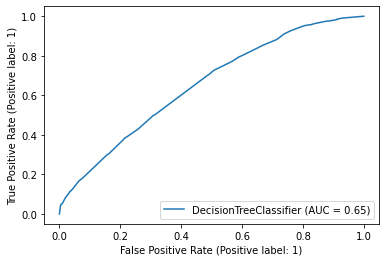



-----------CONFUSION MATRIX-----------



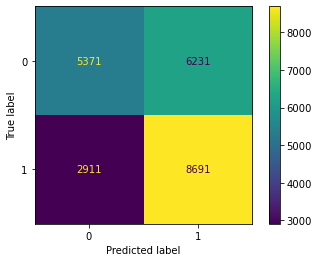

DecisionTreeClassifier(max_depth=10)

In [1252]:
dtc = DecisionTreeClassifier(max_depth=10)
report(dtc,trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.8413246647704186
Testing Score = 0.6581623857955525
Cross Validation Score = 0.7083059764782843
ROC-AUC Score = 0.7183955824271184


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.66      0.65      0.66     11602
           1       0.66      0.67      0.66     11602

    accuracy                           0.66     23204
   macro avg       0.66      0.66      0.66     23204
weighted avg       0.66      0.66      0.66     23204



-----------ROC AUC CURVE-----------



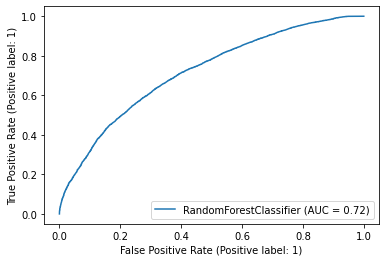



-----------CONFUSION MATRIX-----------



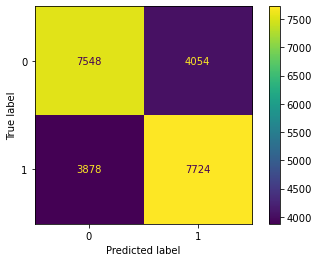

RandomForestClassifier(max_depth=18)

In [1253]:
rf = RandomForestClassifier(max_depth=18)
report(rf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.9260278526836836
Testing Score = 0.6591966902258232
Cross Validation Score = 0.7161379456161425
ROC-AUC Score = 0.72190943084699


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.63      0.77      0.69     11602
           1       0.70      0.55      0.62     11602

    accuracy                           0.66     23204
   macro avg       0.67      0.66      0.66     23204
weighted avg       0.67      0.66      0.66     23204



-----------ROC AUC CURVE-----------



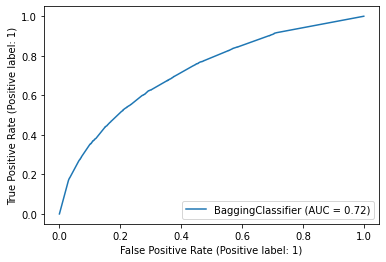



-----------CONFUSION MATRIX-----------



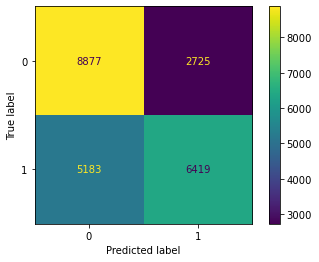

BaggingClassifier(random_state=441)

In [1254]:
bg = BaggingClassifier(n_estimators=10, random_state=seed)
report(bg, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

[06:03:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score = 0.7208636548335857
Testing Score = 0.6370022409929322
[06:03:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:03:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

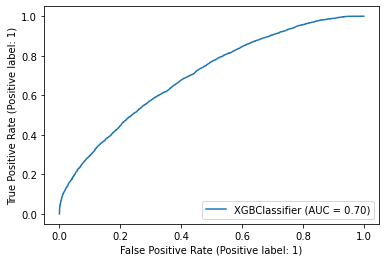



-----------CONFUSION MATRIX-----------



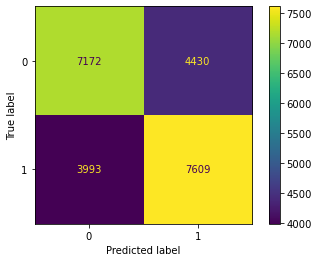

In [1255]:
xgbclf = xgb.XGBClassifier(random_state=seed, )
xgbclf = report(xgbclf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.5350005540984818
Testing Score = 0.5344768143423547
Cross Validation Score = 0.5354068637201691
ROC-AUC Score = 0.5631649776484632


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

           0       0.55      0.38      0.45     11602
           1       0.53      0.68      0.60     11602

    accuracy                           0.53     23204
   macro avg       0.54      0.53      0.52     23204
weighted avg       0.54      0.53      0.52     23204



-----------ROC AUC CURVE-----------



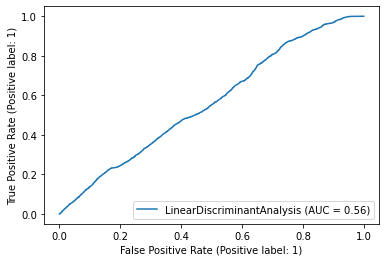



-----------CONFUSION MATRIX-----------



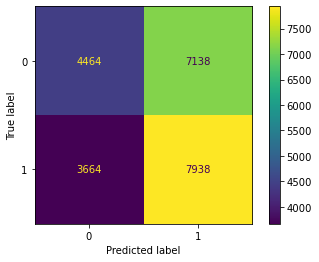

In [1256]:
lda = LinearDiscriminantAnalysis()
lda = report(lda, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

In [1257]:
save(xgbclf, 10)

'Models/model_10.pkl'

# <center>VERSION 11</center>

In [2809]:
df11 = df.copy()

In [2810]:
df11.drop('Region_Code', axis=1, inplace=True)

In [2811]:
df11.head()

,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,C5,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,C5,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,C24,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,C8,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [2812]:
df11[df11.Response==1].pivot_table(index='City_Code', values='Reco_Policy_Premium', aggfunc=np.mean).sort_values(by='Reco_Policy_Premium')

,Reco_Policy_Premium
City_Code,
C29,11030.268132
C35,11369.200000
C34,11751.966667
C32,11919.365217
C20,12196.393396
C4,12299.172328
C23,12333.515385
C25,12387.150000
C33,12511.394366


In [2813]:
city_value = {
    '1':['C29', 'C35', 'C34', 'C32', 'C20', 'C4'],
    '2':['C23', 'C25', 'C33', 'C16','C6', 'C13'], 
    '3':['C9', 'C14', 'C28', 'C27', 'C18', 'C10'],
    '4':['C5', 'C11', 'C3','C17', 'C22', 'C31'],
    '5':['C8', 'C12', 'C21', 'C7', 'C19', 'C2'],
    '6':['C15','C24', 'C26', 'C36', 'C1', 'C30'],
}

In [2814]:
def set_city_value(x):
    for i in range(1, 7):
        if x in city_value[str(i)]:
            return i

In [2815]:
df11.City_Code = df11.City_Code.apply(set_city_value)

In [2816]:
df11.Holding_Policy_Duration.unique()

array(['14+', nan, '1.0', '3.0', '5.0', '9.0', '14.0', '7.0', '2.0',
       '11.0', '10.0', '8.0', '6.0', '4.0', '13.0', '12.0'], dtype=object)

In [2817]:
df11.Holding_Policy_Duration = df11.Holding_Policy_Duration.str.replace('14\+', '15')

df11.Holding_Policy_Duration = df11.Holding_Policy_Duration.fillna(0)

df11.Holding_Policy_Duration = df11.Holding_Policy_Duration.apply(lambda x: float(x)).astype('int64')

In [2818]:
df11.Holding_Policy_Type.unique()

array([ 3., nan,  1.,  4.,  2.])

In [2819]:
df11.Holding_Policy_Type = df11.Holding_Policy_Type.fillna(0).astype(int)

In [2820]:
df.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


df11['acc_type_reco_ins_type'] = (df.Accomodation_Type+df.Reco_Insurance_Type).str.lower()

In [2821]:
df[(df.Reco_Insurance_Type=='Joint') & (df.Accomodation_Type=='Owned') &(df.Response==1)]

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
7,C1,3175,Owned,Joint,75,73,Yes,X4,9.0,4.0,17,29344.0,1
9,C1,530,Owned,Joint,59,26,Yes,NaN,7.0,4.0,18,21100.8,1
48,C2,2858,Owned,Joint,57,55,Yes,X4,8.0,4.0,17,28260.0,1
88,C1,1154,Owned,Joint,66,64,Yes,X4,14+,3.0,7,24192.0,1
165,C27,1176,Owned,Joint,39,38,Yes,X4,14+,3.0,17,12014.8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50708,C33,2243,Owned,Joint,34,30,Yes,NaN,1.0,3.0,21,15168.0,1
50709,C1,69,Owned,Joint,74,73,Yes,NaN,NaN,NaN,17,38304.0,1
50718,C1,6,Owned,Joint,74,67,Yes,X2,14+,4.0,17,29178.8,1
50829,C1,46,Owned,Joint,63,59,Yes,X3,14+,1.0,15,30003.2,1


df11.drop(['Accomodation_Type', 'Reco_Insurance_Type'], axis=1, inplace=True)

In [2822]:
# Accomodation Type - 

# 0 - Rented
# 1 - Owned

In [2823]:
df11.Accomodation_Type = df11.Accomodation_Type.apply(
    lambda x: 0 if (x == 'Rented') else 1).astype('category')

In [2824]:
# Reco_Isurance_Type

# 0 - Individual
# 1 - Joint

In [2825]:
df11.Reco_Insurance_Type = df11.Reco_Insurance_Type.apply(
    lambda x: 0 if (x == 'Individual') else 1).astype('category')

In [2826]:
# Is_Spouse

# 0 - No
# 1 - Yes

In [2827]:
df11.Is_Spouse = df11.Is_Spouse.apply(lambda x: 0 if (x == 'No') else 1).astype('category')

In [2828]:
df11.Reco_Policy_Cat = df11.Reco_Policy_Cat.astype('category')

In [2829]:
df11['Health Indicator'].isna().sum()

11691

In [2830]:
df11['Health Indicator'].value_counts()

X1    13010
X2    10332
X3     6762
X4     5743
X5     1727
X6     1280
X7      196
X8       78
X9       63
Name: Health Indicator, dtype: int64

In [2831]:
df11['Health Indicator'].fillna('X0', inplace=True)

In [2832]:
df11['Health Indicator'] = df11['Health Indicator'].str[1]

In [2833]:
df11.Reco_Policy_Premium = np.log10(df11.Reco_Policy_Premium)

In [2834]:
df11 = df11.astype(float)

In [2835]:
df11.Holding_Policy_Type = df11.Holding_Policy_Type.astype('int')
df11.Holding_Policy_Type = df11.Holding_Policy_Type.astype('category')

In [2836]:
df11.Upper_Age = np.log10(df11.Upper_Age)
df11.Lower_Age = np.log10(df11.Lower_Age)

In [2837]:
df11.head()

,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,4.0,0.0,0.0,1.556303,1.556303,0.0,1.0,15.0,3,22.0,4.065505,0.0
1,4.0,1.0,1.0,1.875061,1.342423,0.0,2.0,0.0,0,22.0,4.484442,0.0
2,4.0,1.0,0.0,1.505150,1.505150,0.0,0.0,1.0,1,19.0,3.872156,1.0
3,6.0,1.0,1.0,1.716003,1.681241,0.0,1.0,15.0,3,19.0,4.249932,0.0
4,5.0,0.0,0.0,1.643453,1.643453,0.0,2.0,3.0,1,16.0,4.017200,0.0


In [2838]:
df11 = pd.get_dummies(df11)

In [2839]:
df11.head()

,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Reco_Policy_Cat,Reco_Policy_Premium,Response,Holding_Policy_Type_0,Holding_Policy_Type_1,Holding_Policy_Type_2,Holding_Policy_Type_3,Holding_Policy_Type_4
0,4.0,0.0,0.0,1.556303,1.556303,0.0,1.0,15.0,22.0,4.065505,0.0,0,0,0,1,0
1,4.0,1.0,1.0,1.875061,1.342423,0.0,2.0,0.0,22.0,4.484442,0.0,1,0,0,0,0
2,4.0,1.0,0.0,1.505150,1.505150,0.0,0.0,1.0,19.0,3.872156,1.0,0,1,0,0,0
3,6.0,1.0,1.0,1.716003,1.681241,0.0,1.0,15.0,19.0,4.249932,0.0,0,0,0,1,0
4,5.0,0.0,0.0,1.643453,1.643453,0.0,2.0,3.0,16.0,4.017200,0.0,0,1,0,0,0


In [2840]:
df11 = df11.astype(float)

---

In [2841]:
df11['is_single_person'] = df11.apply(lambda x:1 if (x.Upper_Age==x.Lower_Age) else 0, 1)

In [2842]:
df11['living_lux'] = df11.apply(lambda x: x.City_Code*x.Accomodation_Type, 1)

In [2843]:
df11['reco_policy_premium'] = df11.apply(lambda x: x.Reco_Policy_Cat*x.Reco_Policy_Premium, 1)

In [2844]:
df11['sum'] = df11.apply(lambda x: x.drop('Response').sum(), 1)

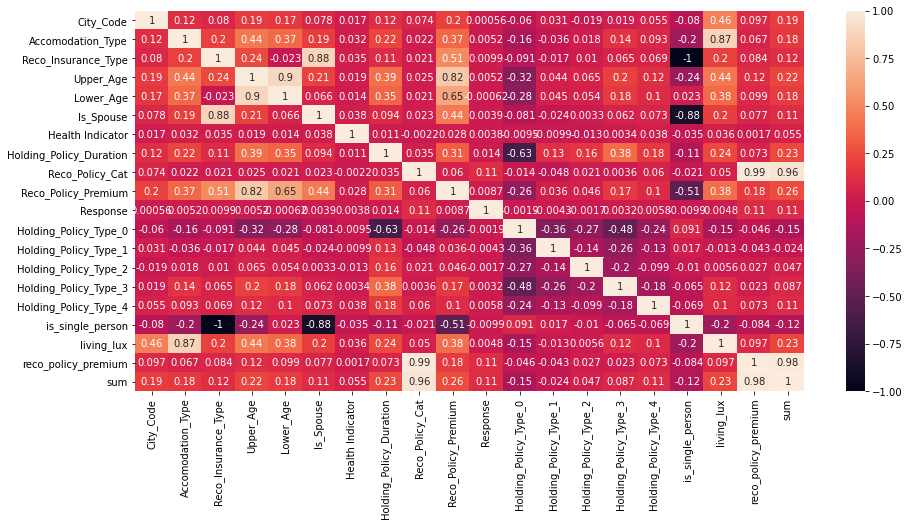

In [2845]:
plt.figure(figsize=(15, 7))
sns.heatmap(df11.corr(), annot=True)

df11.Reco_Policy_Cat = df11.Reco_Policy_Cat.astype('category')

df11 = pd.get_dummies(df11)

In [2846]:
df11.head()

,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Reco_Policy_Cat,Reco_Policy_Premium,Response,Holding_Policy_Type_0,Holding_Policy_Type_1,Holding_Policy_Type_2,Holding_Policy_Type_3,Holding_Policy_Type_4,is_single_person,living_lux,reco_policy_premium,sum
0,4.0,0.0,0.0,1.556303,1.556303,0.0,1.0,15.0,22.0,4.065505,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,89.441111,140.619221
1,4.0,1.0,1.0,1.875061,1.342423,0.0,2.0,0.0,22.0,4.484442,0.0,1.0,0.0,0.0,0.0,0.0,0,4.0,98.657729,141.359655
2,4.0,1.0,0.0,1.505150,1.505150,0.0,0.0,1.0,19.0,3.872156,1.0,0.0,1.0,0.0,0.0,0.0,1,4.0,73.570969,111.453425
3,6.0,1.0,1.0,1.716003,1.681241,0.0,1.0,15.0,19.0,4.249932,0.0,0.0,0.0,0.0,1.0,0.0,0,6.0,80.748703,138.395880
4,5.0,0.0,0.0,1.643453,1.643453,0.0,2.0,3.0,16.0,4.017200,0.0,0.0,1.0,0.0,0.0,0.0,1,0.0,64.275205,99.579311


In [2847]:
# df11 = df11.astype(int)

## Model Building

In [2848]:
x = df11.drop('Response', axis=1)
y = df11.Response

trainx, testx, trainy, testy = train_test_split(x, y, stratify=y, test_size=0.30, random_state=441)

trainx = trainx.astype('int')
testx = testx.astype('int')

In [2849]:
pca = PCA(n_components=3)

In [2850]:
trainx.head()

,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Reco_Policy_Cat,Reco_Policy_Premium,Holding_Policy_Type_0,Holding_Policy_Type_1,Holding_Policy_Type_2,Holding_Policy_Type_3,Holding_Policy_Type_4,is_single_person,living_lux,reco_policy_premium,sum
6614,6.0,1.0,0.0,1.748188,1.748188,0.0,3.0,0.0,17.0,4.210586,1.0,0.0,0.0,0.0,0.0,1,6.0,71.579962,114.286925
6275,6.0,1.0,1.0,1.707570,1.612784,1.0,0.0,2.0,18.0,4.227244,0.0,0.0,0.0,0.0,1.0,0,6.0,76.090388,119.637986
13555,1.0,1.0,0.0,1.591065,1.591065,0.0,0.0,4.0,5.0,3.888067,0.0,0.0,0.0,1.0,0.0,1,1.0,19.440336,40.510532
47740,5.0,0.0,0.0,1.740363,1.740363,0.0,0.0,2.0,2.0,4.136847,0.0,1.0,0.0,0.0,0.0,1,0.0,8.273695,26.891267
13791,5.0,0.0,0.0,1.690196,1.690196,0.0,2.0,0.0,7.0,3.977906,1.0,0.0,0.0,0.0,0.0,1,0.0,27.845345,51.203644


In [2851]:
cols_to_pca = ['Reco_Policy_Premium','reco_policy_premium','sum']

In [2852]:
tr = trainx[cols_to_pca]
tr.head(3)

,Reco_Policy_Premium,reco_policy_premium,sum
6614,4.210586,71.579962,114.286925
6275,4.227244,76.090388,119.637986
13555,3.888067,19.440336,40.510532


In [2853]:
tt = testx[cols_to_pca]
tt.head(3)

,Reco_Policy_Premium,reco_policy_premium,sum
30646,3.925725,27.480072,53.388520
22694,4.284295,51.411544,80.373538
17535,4.205637,8.411275,29.081700


In [2854]:
pca.fit(tr)
tr = pca.transform(tr)
tt = pca.transform(tt)

In [2855]:
tr = pd.DataFrame(tr, columns=['a', 'b', 'c'], index=trainx.index)
tt = pd.DataFrame(tt,  columns=['a', 'b', 'c'], index=testx.index)

In [2856]:
# trainx = pd.concat([trainx, tr], axis=1)
# testx = pd.concat([testx, tt], axis=1)

# trainx.drop(cols_to_pca, inplace=True, axis=1)
# testx.drop(cols_to_pca, inplace=True, axis=1)

In [2857]:
pca.explained_variance_ratio_

array([9.90219984e-01, 9.76045366e-03, 1.95624548e-05])

In [2858]:
# save(pca, 'pca', 1)

## Oversampling V11

In [2859]:
ovrs = SMOTE(random_state=seed)
trainx, trainy = ovrs.fit_resample(trainx, trainy)
testx, testy = ovrs.fit_resample(testx, testy)

Training Score = 0.6014554320121163
Testing Score = 0.5959748319255301
Cross Validation Score = 0.6005876011283716
ROC-AUC Score = 0.6311343180967823


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

         0.0       0.60      0.56      0.58     11602
         1.0       0.59      0.63      0.61     11602

    accuracy                           0.60     23204
   macro avg       0.60      0.60      0.60     23204
weighted avg       0.60      0.60      0.60     23204



-----------ROC AUC CURVE-----------



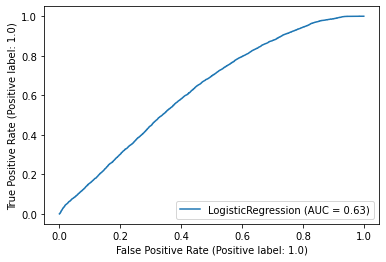



-----------CONFUSION MATRIX-----------



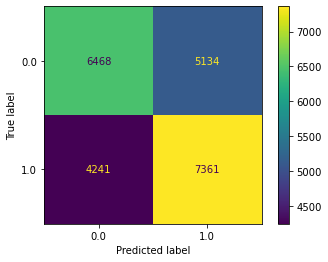

LogisticRegression(random_state=441)

In [2700]:
lr = LogisticRegression(random_state=seed)
report(lr, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.6326142366369916
Testing Score = 0.626486812618514
Cross Validation Score = 0.6183015953106257
ROC-AUC Score = 0.6941417846657578


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

         0.0       0.59      0.81      0.68     11602
         1.0       0.70      0.44      0.54     11602

    accuracy                           0.63     23204
   macro avg       0.65      0.63      0.61     23204
weighted avg       0.65      0.63      0.61     23204



-----------ROC AUC CURVE-----------



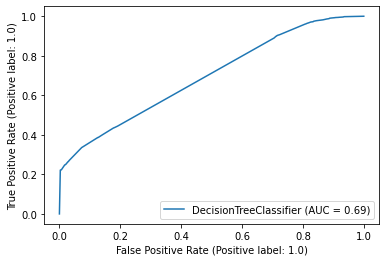



-----------CONFUSION MATRIX-----------



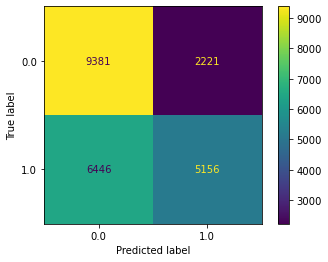

DecisionTreeClassifier(max_depth=10)

In [2701]:
dtc = DecisionTreeClassifier(max_depth=10)
report(dtc,trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.7239666063314987
Testing Score = 0.7209532839165661
Cross Validation Score = 0.7093412733795743
ROC-AUC Score = 0.7947887197105421


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

         0.0       0.71      0.75      0.73     11602
         1.0       0.74      0.69      0.71     11602

    accuracy                           0.72     23204
   macro avg       0.72      0.72      0.72     23204
weighted avg       0.72      0.72      0.72     23204



-----------ROC AUC CURVE-----------



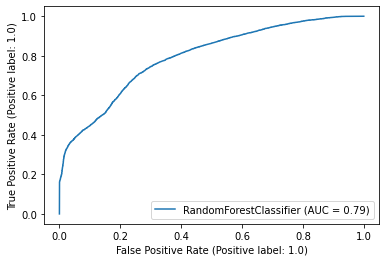



-----------CONFUSION MATRIX-----------



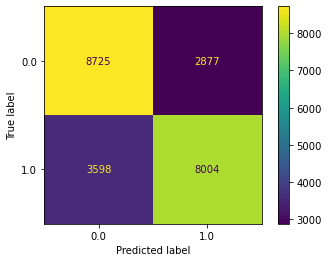

RandomForestClassifier(max_depth=10)

In [2702]:
rf = RandomForestClassifier(max_depth=10)
report(rf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.9867939861844779
Testing Score = 0.7334080330977417
Cross Validation Score = 0.7808400806260386
ROC-AUC Score = 0.8052900625738431


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

         0.0       0.69      0.85      0.76     11602
         1.0       0.80      0.62      0.70     11602

    accuracy                           0.73     23204
   macro avg       0.75      0.73      0.73     23204
weighted avg       0.75      0.73      0.73     23204



-----------ROC AUC CURVE-----------



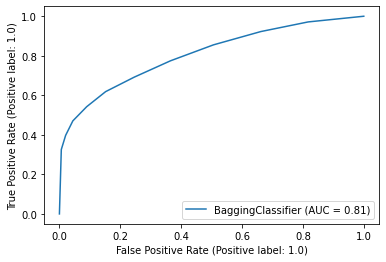



-----------CONFUSION MATRIX-----------



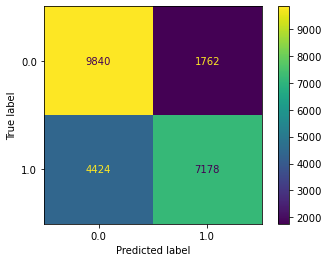

BaggingClassifier(random_state=441)

In [2703]:
bg = BaggingClassifier(random_state=seed)
report(bg, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.6015847216578627
Testing Score = 0.5948112394414756
Cross Validation Score = 0.6001074124628681
ROC-AUC Score = 0.633758903476836


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

         0.0       0.60      0.56      0.58     11602
         1.0       0.59      0.63      0.61     11602

    accuracy                           0.59     23204
   macro avg       0.60      0.59      0.59     23204
weighted avg       0.60      0.59      0.59     23204



-----------ROC AUC CURVE-----------



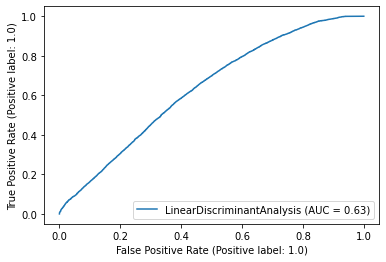



-----------CONFUSION MATRIX-----------



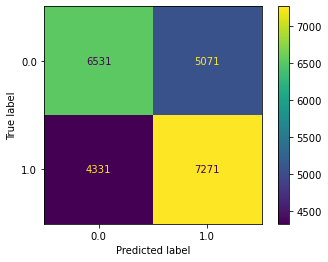

In [2705]:
lda = LinearDiscriminantAnalysis()
lda = report(lda, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

[12:51:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score = 0.8573935207417531
Testing Score = 0.8264954318220996
[12:51:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

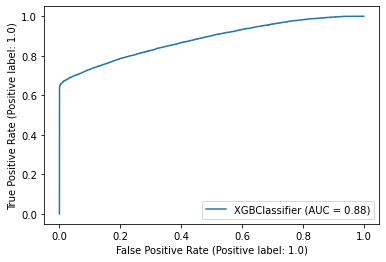



-----------CONFUSION MATRIX-----------



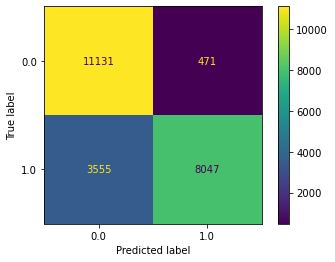

In [2860]:
xgbclf = xgb.XGBClassifier(random_state=seed, )
xgbclf = report(xgbclf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

In [2861]:
save(xgbclf, '11xgb1')

'Models/model_11xgb1.pkl'

[12:51:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Voting] ...................... (1 of 4) Processing xgb, total=   2.8s
[Voting] ....................... (2 of 4) Processing bg, total=   4.0s
[Voting] ....................... (3 of 4) Processing rf, total=   6.2s
[Voting] ...................... (4 of 4) Processing dtc, total=   0.4s
Training Score = 0.9303313508920985
Testing Score = 0.806455783485606
[12:51:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Voting] .................

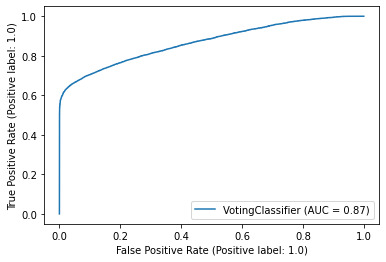



-----------CONFUSION MATRIX-----------



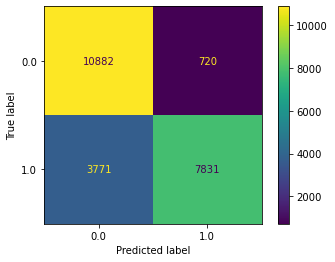

In [2862]:
rf = RandomForestClassifier(max_depth=10)
xgbclf = xgb.XGBClassifier(random_state=seed, )
bg = BaggingClassifier(random_state=seed)
dtc = DecisionTreeClassifier(max_depth=10)

vclf = VotingClassifier([
    ('xgb', xgbclf), ('bg', bg), ('rf', rf), ('dtc', dtc)], verbose=True,voting='soft')

vclf = report(vclf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

In [2863]:
save(vclf, '11vclf1')

'Models/model_11vclf1.pkl'

# <center>VERSION 12</center>

In [2922]:
df12 = df.copy()

In [2923]:
df12.drop('Region_Code', axis=1, inplace=True)

In [2924]:
df12.head()

,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,C5,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,C5,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,C24,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,C8,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [2925]:
df12[df12.Response==1].pivot_table(index='City_Code', values='Reco_Policy_Premium', aggfunc=np.mean).sort_values(by='Reco_Policy_Premium')

,Reco_Policy_Premium
City_Code,
C29,11030.268132
C35,11369.200000
C34,11751.966667
C32,11919.365217
C20,12196.393396
C4,12299.172328
C23,12333.515385
C25,12387.150000
C33,12511.394366


In [2926]:
city_value = {
    '1':['C29', 'C35', 'C34', 'C32', 'C20', 'C4'],
    '2':['C23', 'C25', 'C33', 'C16','C6', 'C13'], 
    '3':['C9', 'C14', 'C28', 'C27', 'C18', 'C10'],
    '4':['C5', 'C11', 'C3','C17', 'C22', 'C31'],
    '5':['C8', 'C12', 'C21', 'C7', 'C19', 'C2'],
    '6':['C15','C24', 'C26', 'C36', 'C1', 'C30'],
}

In [2927]:
def set_city_value(x):
    for i in range(1, 7):
        if x in city_value[str(i)]:
            return i

In [2928]:
df12.City_Code = df12.City_Code.apply(set_city_value)

In [2929]:
df12.Holding_Policy_Duration.unique()

array(['14+', nan, '1.0', '3.0', '5.0', '9.0', '14.0', '7.0', '2.0',
       '11.0', '10.0', '8.0', '6.0', '4.0', '13.0', '12.0'], dtype=object)

In [2930]:
df12.Holding_Policy_Duration = df12.Holding_Policy_Duration.str.replace('14\+', '15')

df12.Holding_Policy_Duration = df12.Holding_Policy_Duration.fillna(0)

df12.Holding_Policy_Duration = df12.Holding_Policy_Duration.apply(lambda x: float(x)).astype('int64')

In [2931]:
df12.Holding_Policy_Type.unique()

array([ 3., nan,  1.,  4.,  2.])

In [2932]:
df12.Holding_Policy_Type = df12.Holding_Policy_Type.fillna(0).astype(int)

In [2933]:
df.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [2934]:
# Accomodation Type - 

# 0 - Rented
# 1 - Owned

In [2935]:
df12.Accomodation_Type = df12.Accomodation_Type.apply(
    lambda x: 0 if (x == 'Rented') else 1).astype('category')

In [2936]:
# Reco_Isurance_Type

# 0 - Individual
# 1 - Joint

In [2937]:
df12.Reco_Insurance_Type = df12.Reco_Insurance_Type.apply(
    lambda x: 0 if (x == 'Individual') else 1).astype('category')

In [2938]:
# Is_Spouse

# 0 - No
# 1 - Yes

In [2939]:
df12.Is_Spouse = df12.Is_Spouse.apply(lambda x: 0 if (x == 'No') else 1).astype('category')

In [2940]:
df12.Reco_Policy_Cat = df12.Reco_Policy_Cat.astype('category')

In [2941]:
df12['Health Indicator'].isna().sum()

11691

In [2942]:
df12['Health Indicator'].value_counts()

X1    13010
X2    10332
X3     6762
X4     5743
X5     1727
X6     1280
X7      196
X8       78
X9       63
Name: Health Indicator, dtype: int64

In [2943]:
df12['Health Indicator'].fillna('X0', inplace=True)

In [2944]:
df12['Health Indicator'] = df12['Health Indicator'].str[1]

In [2945]:
df12.Reco_Policy_Premium = np.log10(df12.Reco_Policy_Premium)

In [2946]:
df12 = df12.astype(float)

In [2947]:
df12.Holding_Policy_Type = df12.Holding_Policy_Type.astype('int')
df12.Holding_Policy_Type = df12.Holding_Policy_Type.astype('category')

In [2948]:
# df12.Upper_Age = np.log10(df12.Upper_Age)
# df12.Lower_Age = np.log10(df12.Lower_Age)
df12.Upper_Age = df12.Upper_Age.apply(bin_age)
df12.Lower_Age = df12.Lower_Age.apply(bin_age)

In [2949]:
df12.head()

,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,4.0,0.0,0.0,2,2,0.0,1.0,15.0,3,22.0,4.065505,0.0
1,4.0,1.0,1.0,4,1,0.0,2.0,0.0,0,22.0,4.484442,0.0
2,4.0,1.0,0.0,2,2,0.0,0.0,1.0,1,19.0,3.872156,1.0
3,6.0,1.0,1.0,3,2,0.0,1.0,15.0,3,19.0,4.249932,0.0
4,5.0,0.0,0.0,2,2,0.0,2.0,3.0,1,16.0,4.017200,0.0


In [2950]:
df12 = pd.get_dummies(df12)

In [2951]:
df12.head()

,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Reco_Policy_Cat,Reco_Policy_Premium,Response,Holding_Policy_Type_0,Holding_Policy_Type_1,Holding_Policy_Type_2,Holding_Policy_Type_3,Holding_Policy_Type_4
0,4.0,0.0,0.0,2,2,0.0,1.0,15.0,22.0,4.065505,0.0,0,0,0,1,0
1,4.0,1.0,1.0,4,1,0.0,2.0,0.0,22.0,4.484442,0.0,1,0,0,0,0
2,4.0,1.0,0.0,2,2,0.0,0.0,1.0,19.0,3.872156,1.0,0,1,0,0,0
3,6.0,1.0,1.0,3,2,0.0,1.0,15.0,19.0,4.249932,0.0,0,0,0,1,0
4,5.0,0.0,0.0,2,2,0.0,2.0,3.0,16.0,4.017200,0.0,0,1,0,0,0


In [2952]:
df12 = df12.astype(float)

---

In [2955]:
# df12['is_single_person'] = df12.apply(lambda x:1 if (x.Upper_Age==x.Lower_Age) else 0, 1)

In [2954]:
df12['living_lux'] = df12.apply(lambda x: x.City_Code*x.Accomodation_Type, 1)

In [2956]:
df12['reco_policy_premium'] = df12.apply(lambda x: x.Reco_Policy_Cat*x.Reco_Policy_Premium, 1)

In [2957]:
df12['sum'] = df12.apply(lambda x: x.drop('Response').sum(), 1)

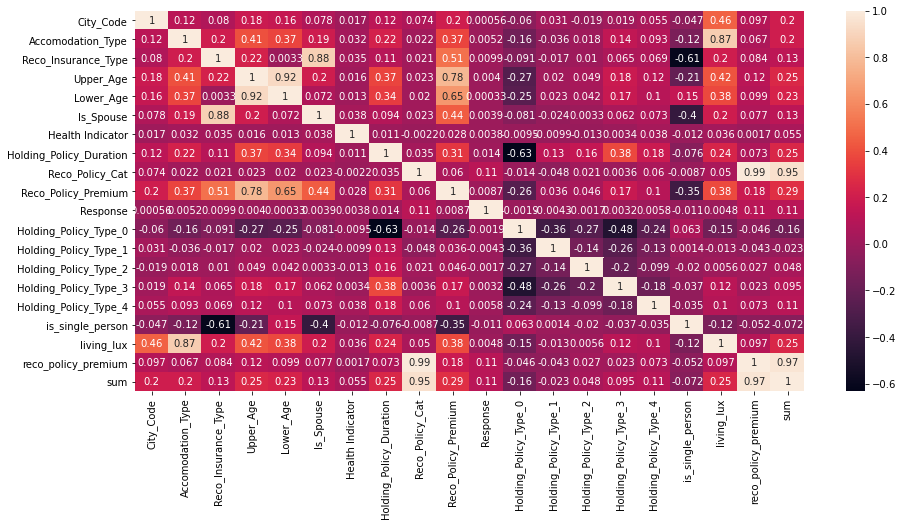

In [2958]:
plt.figure(figsize=(15, 7))
sns.heatmap(df12.corr(), annot=True)

In [2959]:
df12.head()

,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Reco_Policy_Cat,Reco_Policy_Premium,Response,Holding_Policy_Type_0,Holding_Policy_Type_1,Holding_Policy_Type_2,Holding_Policy_Type_3,Holding_Policy_Type_4,is_single_person,living_lux,reco_policy_premium,sum
0,4.0,0.0,0.0,2.0,2.0,0.0,1.0,15.0,22.0,4.065505,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,89.441111,141.506616
1,4.0,1.0,1.0,4.0,1.0,0.0,2.0,0.0,22.0,4.484442,0.0,1.0,0.0,0.0,0.0,0.0,0,4.0,98.657729,143.142171
2,4.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,19.0,3.872156,1.0,0.0,1.0,0.0,0.0,0.0,1,4.0,73.570969,112.443125
3,6.0,1.0,1.0,3.0,2.0,0.0,1.0,15.0,19.0,4.249932,0.0,0.0,0.0,0.0,1.0,0.0,0,6.0,80.748703,139.998635
4,5.0,0.0,0.0,2.0,2.0,0.0,2.0,3.0,16.0,4.017200,0.0,0.0,1.0,0.0,0.0,0.0,1,0.0,64.275205,100.292406


In [2960]:
# df12 = df12.astype(int)

## Model Building

In [2961]:
x = df12.drop('Response', axis=1)
y = df12.Response

trainx, testx, trainy, testy = train_test_split(x, y, stratify=y, test_size=0.30, random_state=441)

trainx = trainx.astype('int')
testx = testx.astype('int')

In [2962]:
pca = PCA(n_components=3)

In [2963]:
trainx.head()

,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Reco_Policy_Cat,Reco_Policy_Premium,Holding_Policy_Type_0,Holding_Policy_Type_1,Holding_Policy_Type_2,Holding_Policy_Type_3,Holding_Policy_Type_4,is_single_person,living_lux,reco_policy_premium,sum
6614,6.0,1.0,0.0,3.0,3.0,0.0,3.0,0.0,17.0,4.210586,1.0,0.0,0.0,0.0,0.0,1,6.0,71.579962,116.790548
6275,6.0,1.0,1.0,3.0,2.0,1.0,0.0,2.0,18.0,4.227244,0.0,0.0,0.0,0.0,1.0,0,6.0,76.090388,121.317632
13555,1.0,1.0,0.0,2.0,2.0,0.0,0.0,4.0,5.0,3.888067,0.0,0.0,0.0,1.0,0.0,1,1.0,19.440336,41.328403
47740,5.0,0.0,0.0,3.0,3.0,0.0,0.0,2.0,2.0,4.136847,0.0,1.0,0.0,0.0,0.0,1,0.0,8.273695,29.410542
13791,5.0,0.0,0.0,3.0,3.0,0.0,2.0,0.0,7.0,3.977906,1.0,0.0,0.0,0.0,0.0,1,0.0,27.845345,53.823251


In [2964]:
cols_to_pca = ['Reco_Policy_Premium','reco_policy_premium','sum']

In [2965]:
tr = trainx[cols_to_pca]
tr.head(3)

,Reco_Policy_Premium,reco_policy_premium,sum
6614,4.210586,71.579962,116.790548
6275,4.227244,76.090388,121.317632
13555,3.888067,19.440336,41.328403


In [2966]:
tt = testx[cols_to_pca]
tt.head(3)

,Reco_Policy_Premium,reco_policy_premium,sum
30646,3.925725,27.480072,54.405796
22694,4.284295,51.411544,84.695840
17535,4.205637,8.411275,31.616912


In [2967]:
pca.fit(tr)
tr = pca.transform(tr)
tt = pca.transform(tt)

In [2968]:
tr = pd.DataFrame(tr, columns=['a', 'b', 'c'], index=trainx.index)
tt = pd.DataFrame(tt,  columns=['a', 'b', 'c'], index=testx.index)

In [2969]:
# trainx = pd.concat([trainx, tr], axis=1)
# testx = pd.concat([testx, tt], axis=1)

# trainx.drop(cols_to_pca, inplace=True, axis=1)
# testx.drop(cols_to_pca, inplace=True, axis=1)

In [2970]:
pca.explained_variance_ratio_

array([9.87695170e-01, 1.22880456e-02, 1.67843113e-05])

In [2971]:
# save(pca, 'pca', 1)

## Oversampling V11

In [2972]:
ovrs = SMOTE(random_state=seed)
trainx, trainy = ovrs.fit_resample(trainx, trainy)
testx, testy = ovrs.fit_resample(testx, testy)

Training Score = 0.5468397916589709
Testing Score = 0.5533959662127219
Cross Validation Score = 0.5425549691900857
ROC-AUC Score = 0.5821202830736047


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

         0.0       0.56      0.47      0.51     11602
         1.0       0.55      0.64      0.59     11602

    accuracy                           0.55     23204
   macro avg       0.55      0.55      0.55     23204
weighted avg       0.55      0.55      0.55     23204



-----------ROC AUC CURVE-----------



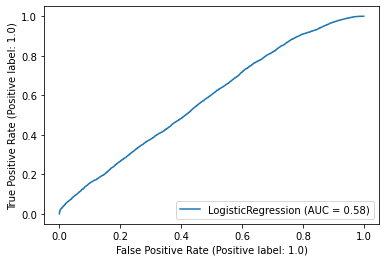



-----------CONFUSION MATRIX-----------



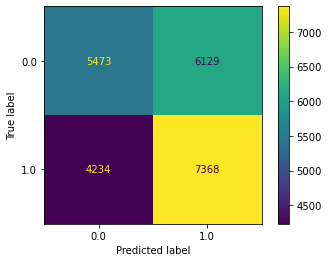

LogisticRegression(random_state=441)

In [2973]:
lr = LogisticRegression(random_state=seed)
report(lr, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.7232093384064128
Testing Score = 0.7249181175659369
Cross Validation Score = 0.6868646552139085
ROC-AUC Score = 0.7830975300402497


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

         0.0       0.66      0.91      0.77     11602
         1.0       0.86      0.54      0.66     11602

    accuracy                           0.72     23204
   macro avg       0.76      0.72      0.72     23204
weighted avg       0.76      0.72      0.72     23204



-----------ROC AUC CURVE-----------



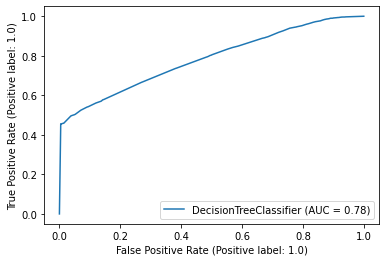



-----------CONFUSION MATRIX-----------



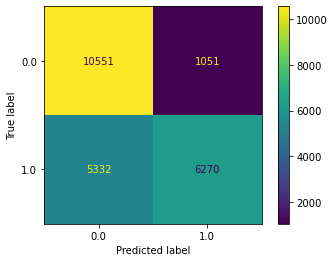

DecisionTreeClassifier(max_depth=10)

In [2974]:
dtc = DecisionTreeClassifier(max_depth=10)
report(dtc,trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.7673340475047098
Testing Score = 0.7565074987071194
Cross Validation Score = 0.7468564670049771
ROC-AUC Score = 0.8291195937453317


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

         0.0       0.71      0.85      0.78     11602
         1.0       0.82      0.66      0.73     11602

    accuracy                           0.76     23204
   macro avg       0.77      0.76      0.75     23204
weighted avg       0.77      0.76      0.75     23204



-----------ROC AUC CURVE-----------



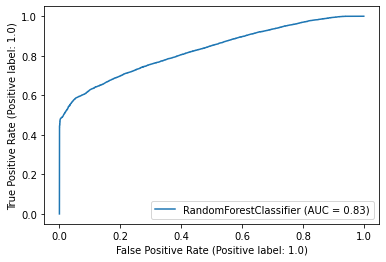



-----------CONFUSION MATRIX-----------



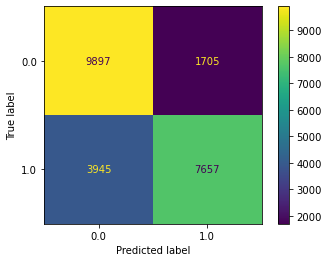

RandomForestClassifier(max_depth=10)

In [2975]:
rf = RandomForestClassifier(max_depth=10)
report(rf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.9851316907391674
Testing Score = 0.7631873814859507
Cross Validation Score = 0.8008073724787007
ROC-AUC Score = 0.8224912724063261


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

         0.0       0.71      0.88      0.79     11602
         1.0       0.85      0.64      0.73     11602

    accuracy                           0.76     23204
   macro avg       0.78      0.76      0.76     23204
weighted avg       0.78      0.76      0.76     23204



-----------ROC AUC CURVE-----------



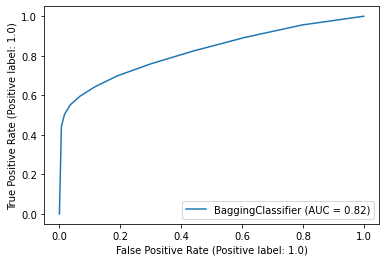



-----------CONFUSION MATRIX-----------



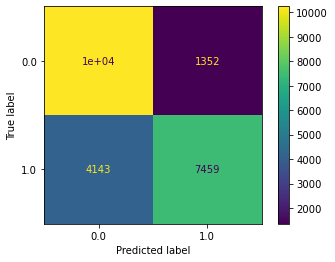

BaggingClassifier(random_state=441)

In [2976]:
bg = BaggingClassifier(random_state=seed)
report(bg, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

Training Score = 0.554209301466514
Testing Score = 0.557921048095156
Cross Validation Score = 0.5538219931205127
ROC-AUC Score = 0.6016550148683861


-----------CLASSIFICATION REPORT-----------

              precision    recall  f1-score   support

         0.0       0.57      0.50      0.53     11602
         1.0       0.55      0.61      0.58     11602

    accuracy                           0.56     23204
   macro avg       0.56      0.56      0.56     23204
weighted avg       0.56      0.56      0.56     23204



-----------ROC AUC CURVE-----------



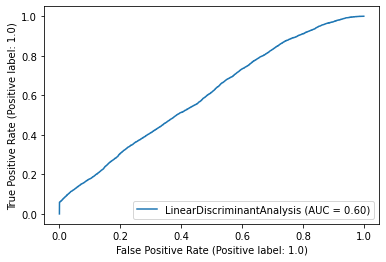



-----------CONFUSION MATRIX-----------



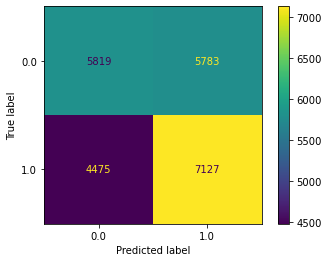

In [2977]:
lda = LinearDiscriminantAnalysis()
lda = report(lda, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

[19:07:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score = 0.849045103616416
Testing Score = 0.8230908464057921
[19:07:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:07:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


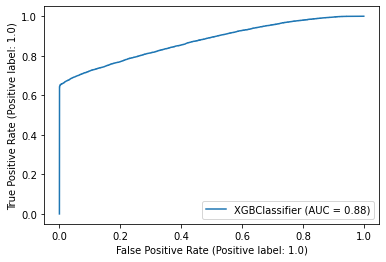



-----------CONFUSION MATRIX-----------



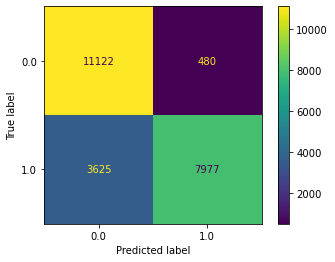

In [2981]:
xgbclf = xgb.XGBClassifier(random_state=seed, )
xgbclf = report(xgbclf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

In [2982]:
save(xgbclf, '12xgb')

'Models/model_12xgb.pkl'

[19:02:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Voting] ...................... (1 of 4) Processing xgb, total=   2.9s
[Voting] ....................... (2 of 4) Processing bg, total=   3.9s
[Voting] ....................... (3 of 4) Processing rf, total=   5.9s
[Voting] ...................... (4 of 4) Processing dtc, total=   0.3s
Training Score = 0.9195633703963652
Testing Score = 0.8076193759696604
[19:02:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Voting] ................

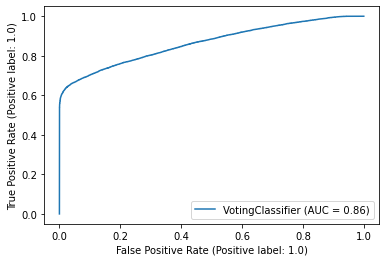



-----------CONFUSION MATRIX-----------



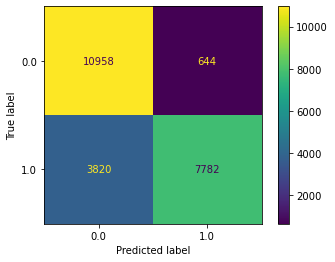

In [2980]:
rf = RandomForestClassifier(max_depth=10)
xgbclf = xgb.XGBClassifier(random_state=seed, )
bg = BaggingClassifier(random_state=seed)
dtc = DecisionTreeClassifier(max_depth=10)

vclf = VotingClassifier([
    ('xgb', xgbclf), ('bg', bg), ('rf', rf), ('dtc', dtc)], verbose=True,voting='soft')

vclf = report(vclf, trainx=trainx, trainy=trainy, testx=testx, testy=testy, cv=1)

In [2983]:
save(vclf, '12vclf')

'Models/model_12vclf.pkl'

In [2998]:
trainx

,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Reco_Policy_Cat,Reco_Policy_Premium,Holding_Policy_Type_0,Holding_Policy_Type_1,Holding_Policy_Type_2,Holding_Policy_Type_3,Holding_Policy_Type_4,is_single_person,living_lux,reco_policy_premium,sum
0,6.000000,1.0,0.00000,3.000000,3.000000,0.00000,3.000000,0.0,17.0,4.210586,1.0,0.0,0.0,0.000000,0.000000,1,6.000000,71.579962,116.790548
1,6.000000,1.0,1.00000,3.000000,2.000000,1.00000,0.000000,2.0,18.0,4.227244,0.0,0.0,0.0,0.000000,1.000000,0,6.000000,76.090388,121.317632
2,1.000000,1.0,0.00000,2.000000,2.000000,0.00000,0.000000,4.0,5.0,3.888067,0.0,0.0,0.0,1.000000,0.000000,1,1.000000,19.440336,41.328403
3,5.000000,0.0,0.00000,3.000000,3.000000,0.00000,0.000000,2.0,2.0,4.136847,0.0,1.0,0.0,0.000000,0.000000,1,0.000000,8.273695,29.410542
4,5.000000,0.0,0.00000,3.000000,3.000000,0.00000,2.000000,0.0,7.0,3.977906,1.0,0.0,0.0,0.000000,0.000000,1,0.000000,27.845345,53.823251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54137,5.000000,1.0,0.00000,4.000000,4.000000,0.00000,1.796677,15.0,22.0,4.312997,0.0,0.0,0.0,0.203323,0.796677,1,5.000000,94.885941,158.995615
54138,1.189330,0.0,0.00000,1.000000,1.000000,0.00000,1.810670,0.0,21.0,3.835019,1.0,0.0,0.0,0.000000,0.000000,1,0.000000,80.535401,112.370420
54139,4.868526,1.0,1.00000,3.000000,1.131474,1.00000,1.000000,0.0,21.0,4.341104,1.0,0.0,0.0,0.000000,0.000000,0,4.868526,91.163182,135.372812
54140,5.955090,1.0,0.04491,2.089820,1.955090,0.04491,2.955090,0.0,2.0,4.090173,1.0,0.0,0.0,0.000000,0.000000,0,5.955090,8.180347,36.225610
